In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE
import torch as torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch import optim
import warnings
import zipfile
import os
import PIL 
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import random
import unicodedata
import string
import matplotlib.ticker as ticker

warnings.simplefilter("ignore")

In [2]:
num_classes = 10
jump = 3
cwd = os.getcwd()
os.chdir(cwd + "\\tiny-imagenet-200\\tiny-imagenet-200")
image_cwd = os.getcwd()
with open("wnids.txt", 'r') as r_file:
    lines = r_file.readlines()
print(len(lines))
classes = [j.split('\n')[0] for j in lines[:jump*num_classes:jump]]
print(classes)

200
['n02124075', 'n04099969', 'n02802426', 'n03970156', 'n03201208', 'n04146614', 'n04507155', 'n03733131', 'n03544143', 'n02437312']


In [3]:
num_train_images_per_class = 400
image_format = "JPEG"
train_data = []
for i in range(num_classes):
    #os.chdir(cwd + "\\train\{}".format(classes[i]))
    os.chdir(image_cwd + "\\train\{}\images".format(classes[i]))
    k = 0
    j = 0
    while j < (num_train_images_per_class + k):
        if os.path.exists("{}_{}.{}".format(classes[i], j, image_format)):
            image = mpimg.imread("{}_{}.{}".format(classes[i], j, image_format))
            if len(image.shape) != 3:
                k += 1
                #print("train error for image : {}_{}.{}".format(classes[i], j, image_format))
            else: 
                #print("{}_{}.{}".format(classes[i], j, image_format), len(image.shape))
                train_data.append(tuple([torch.from_numpy(image.transpose(2, 0, 1)/255.0), i]))
            j += 1
        else:
            break
print(len(train_data))

valid_data = []
test_data = []
num_valid_images_per_class = 10
num_test_images_per_class = 10

os.chdir(image_cwd + "\\val")
with open("val_annotations.txt", 'r') as r_file:
    lines = r_file.readlines()

os.chdir(image_cwd + "\\val\images")
val_dataset_filename = [line.split("\t")[0] for line in lines]
val_dataset_labels = [line.split("\t")[1] for line in lines]
for i in range(num_classes):
    indices = np.where(np.array(val_dataset_labels) == classes[i])[0]
    k = 0
    j = 0
    while j < (num_valid_images_per_class + k):
        if os.path.exists("{}".format(val_dataset_filename[indices[j]])):
            image = mpimg.imread("{}".format(val_dataset_filename[indices[j]]))
            if len(image.shape) != 3:
                k += 1
                #print("valid error for image : {}".format(val_dataset_filename[indices[j]]))
            else:
                valid_data.append(tuple([torch.from_numpy(image.transpose(2, 0, 1)/255.0), i]))
            j += 1
        else:
            break
    k = 0
    t = j
    while t < ( j + num_test_images_per_class + k):
        if os.path.exists("{}".format(val_dataset_filename[indices[t]])):
            image = mpimg.imread("{}".format(val_dataset_filename[indices[t]]))
            if len(image.shape) != 3:
                k += 1
                #print("test error for image : {}".format(val_dataset_filename[indices[t]]))
            else:
                test_data.append(tuple([torch.from_numpy(image.transpose(2, 0, 1)/255.0), i]))
            t += 1
        else:
            break
print(len(valid_data))
print(len(test_data))

y_mapping = np.identity(num_classes)

4000
100
100


In [4]:
loaders = {
    'train' : DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : DataLoader(test_data, 
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=1)
}
learning_rate = 0.001

In [14]:
def hw6q1evaluate(loaders, loss_func,  model, y_mapping, model_name):
    # Test the model
    model.eval()
    original_labels = list()
    with torch.no_grad():
        counter = 0
        total_loss = 0.0
        for (images, labels) in loaders['test']:
            output = model(images.float())
            #pred_y = torch.max(test_output, 1)[1].data.squeeze()
            encoded_labels = list()
            counter = labels.shape[0]
            for t in range(counter):
                encoded_labels.append(y_mapping[labels[t]])
            encoded_labels = torch.from_numpy(np.array(encoded_labels)).to(torch.float64)
            
            loss = loss_func(output, encoded_labels)
            accuracy = (np.argmax(output, 1) == labels).sum().item() / float(labels.size(0))
            
            total_loss += loss.item()
            original_labels = labels
            
            activation_maps = list()
            #total_layers = len(model.features)
            layer_names = list()
            counter_activation_layers = 0
            if model_name == 'alexnet':
                x = images
                x = x[counter - 1].unsqueeze(0).float()
                for idx, operation in enumerate(model.features):
                    x = operation(x)
                    if isinstance(model.features[idx], tuple([torch.nn.modules.activation.ReLU, torch.nn.modules.activation.Tanh, torch.nn.modules.activation.LeakyReLU, torch.nn.modules.activation.Softmax])):
                        #print("x.shape : ", x.shape)
                        activation_maps.append(x[0, 0, :, :])
                        layer_names.append('layer {}'.format(idx))
                        counter_activation_layers += 1

                y = images
                flattened_output = torch.flatten(model.avgpool(model.features(y.float())), 1)
            elif model_name == 'resnet50':
                x = images.float()
                #print("initial ", x.shape)
                for name, module in model.named_modules():
                    #print("1", name)
                    if 'downsample' in str(name):
                        continue
                    else:
                        if isinstance(module, tuple([torch.nn.modules.container.Sequential])) or 'Bottleneck' in str(type(module)) or 'resnet.ResNet' in str(type(module)):
                            continue
                        elif isinstance(module, tuple([torch.nn.modules.pooling.AdaptiveAvgPool2d])):
                            x = module(x)
                            #print("2", name, x.shape)
                            flattened_output = x = torch.flatten(x, 1)
                            #print("3", name, x.shape)
                        else:
                            x = module(x)
                            #print("4", name, x.shape)
                            if isinstance(module, tuple([torch.nn.modules.activation.ReLU, torch.nn.modules.activation.Tanh, torch.nn.modules.activation.LeakyReLU, torch.nn.modules.activation.Softmax])):
                                #print("x.shape : ", x.shape)
                                activation_maps.append(x[counter - 1, 0, :, :])
                                layer_names.append('{}'.format(name))
                                counter_activation_layers += 1
            
            #print(len(activation_maps))
            #print("counter_activation_layers: ",  counter_activation_layers)
            plt.subplot(int(counter_activation_layers / 6) + 1, 6, 1)
            plt.title("original")
            plt.imshow(images[counter - 1, 0, :, :])
            for j in range(counter_activation_layers):
                plt.subplot(int(counter_activation_layers / 6) + 1, 6, j + 2)
                plt.title("{}".format(layer_names[j]))
                plt.imshow(activation_maps[j])
            plt.subplots_adjust(left=2.0,
                    bottom=3.0, 
                    right=4.0, 
                    top=4.0, 
                    wspace=0.4, 
                    hspace=0.4)
            plt.show()
        return total_loss/counter, accuracy, flattened_output, original_labels

def hw6q1train(loaders, model, loss_func, optimizer, y_mapping, num_epochs, model_name):
    model.train()
    total_step = len(loaders['train'])
    #print("total_step : ", total_step)
    train_loss_array = list()
    test_loss_array = list()
    flattened_outputs_list = list()
    original_labels_list = list()
    for i in range(num_epochs):
        total_loss = 0.0
        for index, (images, labels) in enumerate(loaders['train']):
            b_x = Variable(images)
            #print(images.shape)
            #print(b_x.shape)
            b_y = Variable(labels)
            
            output = model(b_x.float())
            
            encoded_labels = list()
            for t in range(labels.shape[0]):
                encoded_labels.append(y_mapping[labels[t]])
            
            encoded_labels = torch.from_numpy(np.array(encoded_labels)).to(torch.float64)
            #print(encoded_labels.shape)
            #print(output.shape)
            
            loss = loss_func(output, encoded_labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            if (index+1) % 20 == 0:
                total_loss += loss.item()
                print ('Epoch [{}/{}] | Step [{}/{}] | Train Loss: {:.4f}'.format(i + 1, num_epochs, index + 1, total_step, loss.item()))
        
        train_loss_array.append(total_loss/(total_step/20))
        test_loss, test_accuracy, flattened_output, original_labels = hw6q1evaluate(loaders, loss_func, model, y_mapping, model_name)
        print("Epoch [{}/{}] | Test loss : {} | Test Accuracy : {} %".format(i + 1, num_epochs, test_loss, test_accuracy * 100))
        test_loss_array.append(test_loss)
        
        if i == 0:
            flattened_outputs_list.append(flattened_output)
            original_labels_list.append(original_labels)
        elif i == (num_epochs - 1):
            flattened_outputs_list.append(flattened_output)
            original_labels_list.append(original_labels)
        
        """
        if len(test_loss_array) >= 4:
            if test_loss_array[len(test_loss_array) - 1] <= test_loss_array[len(test_loss_array) - 2] and test_loss_array[len(test_loss_array) - 1] <= test_loss_array[len(test_loss_array) - 3]:
                #print("I am continuing")
                continue
            else:
                #print("I am breaking")
                print("difference 1 : ", test_loss_array[len(test_loss_array) - 1] - test_loss_array[len(test_loss_array) - 1])
                print("difference 2 : ", test_loss_array[len(test_loss_array) - 2] - test_loss_array[len(test_loss_array) - 1])
                flattened_outputs_list.append(flattened_output)
                original_labels_list.append(original_labels)
                break
        """
    
    #print(train_loss_array)
    plt.plot(list(range(len(train_loss_array))), train_loss_array, '-go')
    plt.title("train loss")
    plt.show()
    plt.plot(list(range(len(test_loss_array))), test_loss_array, '-bo')
    plt.title("test loss")
    plt.show()
    return flattened_outputs_list, original_labels_list

def hw6q1TSNE(flattened_outputs_list, original_Y_list, num_epochs):
    #print(np.squeeze(flattened_outputs_list[i], axis = -1).dtype)
    #print(len(flattened_outputs_list))
    #print(flattened_outputs_list[0].shape)
    flattened_outputs_list = np.array(flattened_outputs_list)
    for i in range(len(flattened_outputs_list)):
        tsne =  TSNE(n_components=2, init='random')
        #print(flattened_outputs_list[i].shape)
        Y_output = tsne.fit_transform(np.squeeze(flattened_outputs_list[i], axis = -1))
        colors = ['black', 'blue', 'green', 'red', 'yellow', 'purple', 'brown', 'magenta', 'cyan', 'orange']
        for j in range(Y_output.shape[0]):
            plt.scatter(Y_output[j, 0], Y_output[j, 1], c = colors[original_Y_list[i][j]])
            plt.annotate(original_Y_list[i][j].item(), (Y_output[j, 0], Y_output[j, 1]))
        #plt.scatter(x_axis, y_axis)
        plt.title("tSNE plot for epoch {}".format(i*(num_epochs - 1) + 1))
        plt.legend()
        plt.show()

In [6]:
alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
#print(alexnet_model.eval())
alexnet_model.classifier[6] = nn.Linear(4096,10)
#print(isinstance(alexnet_model.features[1], tuple([torch.nn.modules.activation.ReLU, torch.nn.modules.activation.Tanh, torch.nn.modules.activation.LeakyReLU, torch.nn.modules.activation.Softmax])))
print(alexnet_model.eval())
loss_func1 = nn.CrossEntropyLoss()
optimizer_sgd1 = optim.SGD(alexnet_model.parameters(), lr = learning_rate, momentum = 0.0)
num_epochs = 50

Using cache found in C:\Users\sanyo/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch [1/50] | Step [20/40] | Train Loss: 2.3023
Epoch [1/50] | Step [40/40] | Train Loss: 2.3036


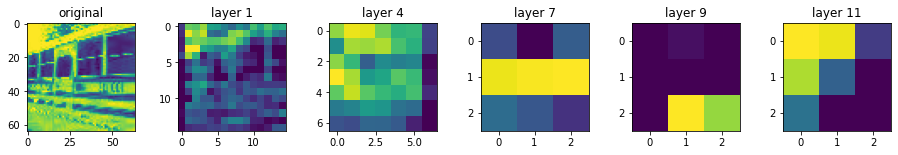

Epoch [1/50] | Test loss : 0.02302629356384277 | Test Accuracy : 10.0 %
Epoch [2/50] | Step [20/40] | Train Loss: 2.3023
Epoch [2/50] | Step [40/40] | Train Loss: 2.3041


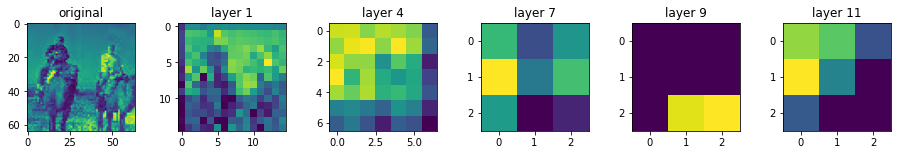

Epoch [2/50] | Test loss : 0.023026282954216003 | Test Accuracy : 10.0 %
Epoch [3/50] | Step [20/40] | Train Loss: 2.3018
Epoch [3/50] | Step [40/40] | Train Loss: 2.3031


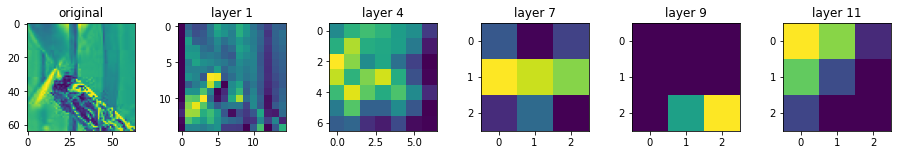

Epoch [3/50] | Test loss : 0.02302627227306366 | Test Accuracy : 10.0 %
Epoch [4/50] | Step [20/40] | Train Loss: 2.3036
Epoch [4/50] | Step [40/40] | Train Loss: 2.3027


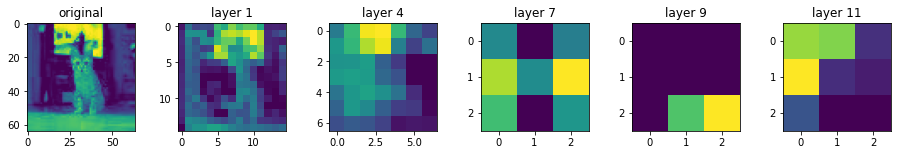

Epoch [4/50] | Test loss : 0.023026261687278747 | Test Accuracy : 10.0 %
Epoch [5/50] | Step [20/40] | Train Loss: 2.3022
Epoch [5/50] | Step [40/40] | Train Loss: 2.3027


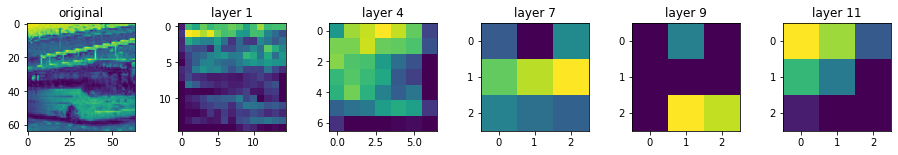

Epoch [5/50] | Test loss : 0.02302625141143799 | Test Accuracy : 10.0 %
Epoch [6/50] | Step [20/40] | Train Loss: 2.3030
Epoch [6/50] | Step [40/40] | Train Loss: 2.3027


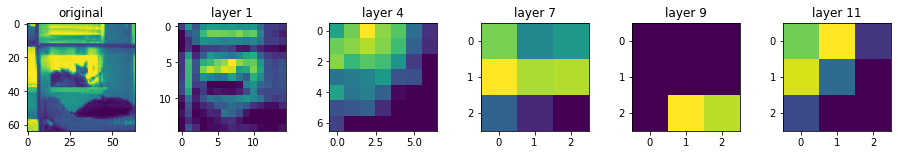

Epoch [6/50] | Test loss : 0.02302624146938324 | Test Accuracy : 10.0 %
Epoch [7/50] | Step [20/40] | Train Loss: 2.3010
Epoch [7/50] | Step [40/40] | Train Loss: 2.3037


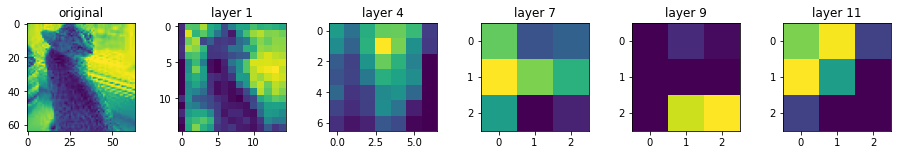

Epoch [7/50] | Test loss : 0.023026231217384337 | Test Accuracy : 10.0 %
Epoch [8/50] | Step [20/40] | Train Loss: 2.3026
Epoch [8/50] | Step [40/40] | Train Loss: 2.3028


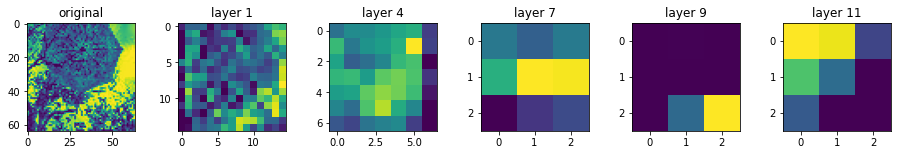

Epoch [8/50] | Test loss : 0.023026221013069153 | Test Accuracy : 10.0 %
Epoch [9/50] | Step [20/40] | Train Loss: 2.3013
Epoch [9/50] | Step [40/40] | Train Loss: 2.3021


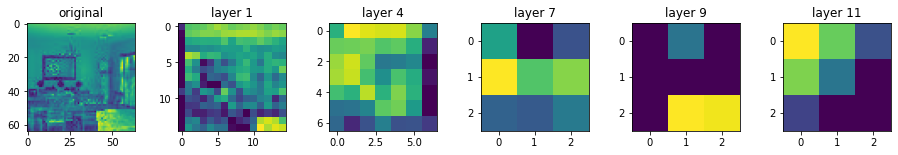

Epoch [9/50] | Test loss : 0.02302621080875397 | Test Accuracy : 10.0 %
Epoch [10/50] | Step [20/40] | Train Loss: 2.3034
Epoch [10/50] | Step [40/40] | Train Loss: 2.3037


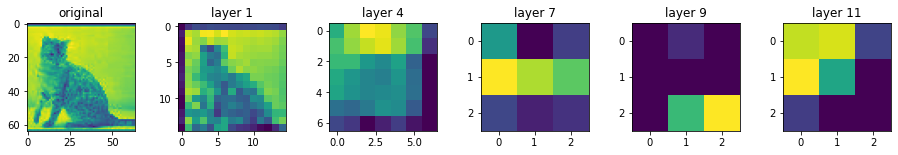

Epoch [10/50] | Test loss : 0.02302620058059692 | Test Accuracy : 10.0 %
Epoch [11/50] | Step [20/40] | Train Loss: 2.3027
Epoch [11/50] | Step [40/40] | Train Loss: 2.3033


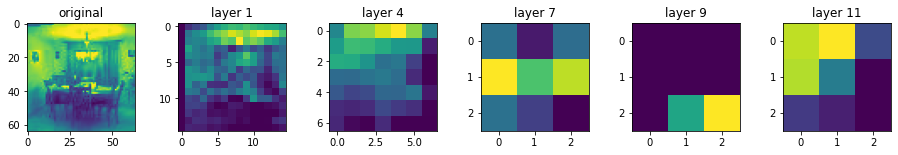

Epoch [11/50] | Test loss : 0.023026190996170044 | Test Accuracy : 10.0 %
Epoch [12/50] | Step [20/40] | Train Loss: 2.3036
Epoch [12/50] | Step [40/40] | Train Loss: 2.3038


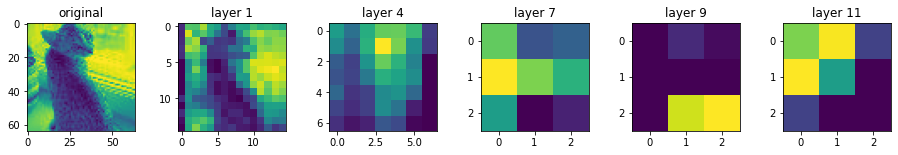

Epoch [12/50] | Test loss : 0.023026180863380433 | Test Accuracy : 10.0 %
Epoch [13/50] | Step [20/40] | Train Loss: 2.3019
Epoch [13/50] | Step [40/40] | Train Loss: 2.3016


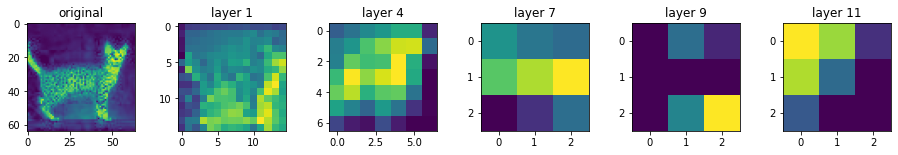

Epoch [13/50] | Test loss : 0.023026171112060546 | Test Accuracy : 10.0 %
Epoch [14/50] | Step [20/40] | Train Loss: 2.3031
Epoch [14/50] | Step [40/40] | Train Loss: 2.3033


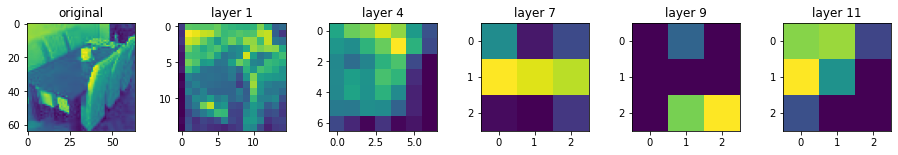

Epoch [14/50] | Test loss : 0.023026161408424378 | Test Accuracy : 10.0 %
Epoch [15/50] | Step [20/40] | Train Loss: 2.3024
Epoch [15/50] | Step [40/40] | Train Loss: 2.3014


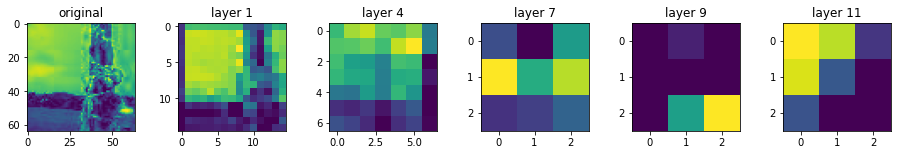

Epoch [15/50] | Test loss : 0.023026151990890503 | Test Accuracy : 10.0 %
Epoch [16/50] | Step [20/40] | Train Loss: 2.3029
Epoch [16/50] | Step [40/40] | Train Loss: 2.3033


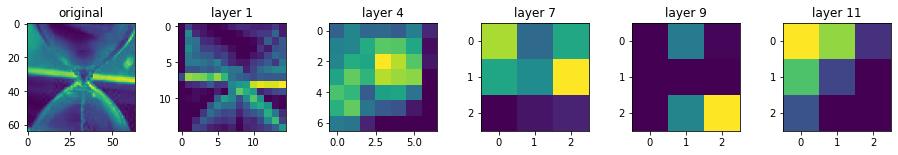

Epoch [16/50] | Test loss : 0.023026142621040347 | Test Accuracy : 10.0 %
Epoch [17/50] | Step [20/40] | Train Loss: 2.3017
Epoch [17/50] | Step [40/40] | Train Loss: 2.3035


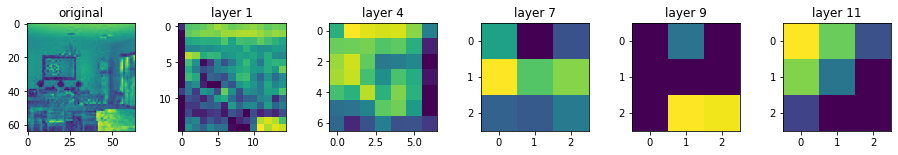

Epoch [17/50] | Test loss : 0.02302613308429718 | Test Accuracy : 10.0 %
Epoch [18/50] | Step [20/40] | Train Loss: 2.3032
Epoch [18/50] | Step [40/40] | Train Loss: 2.3024


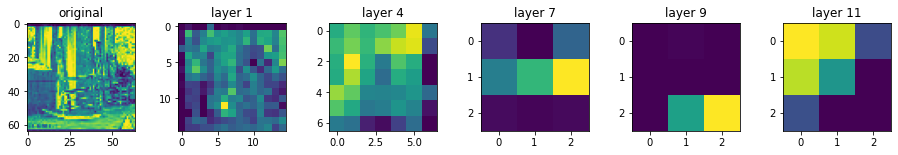

Epoch [18/50] | Test loss : 0.02302612376213074 | Test Accuracy : 10.0 %
Epoch [19/50] | Step [20/40] | Train Loss: 2.3022
Epoch [19/50] | Step [40/40] | Train Loss: 2.3026


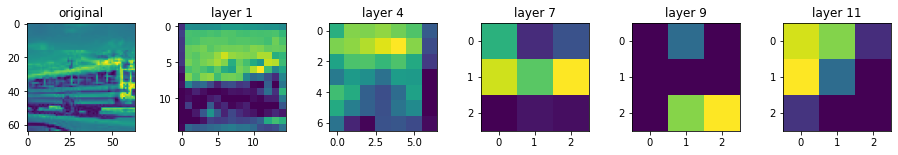

Epoch [19/50] | Test loss : 0.0230261146068573 | Test Accuracy : 10.0 %
Epoch [20/50] | Step [20/40] | Train Loss: 2.3005
Epoch [20/50] | Step [40/40] | Train Loss: 2.3041


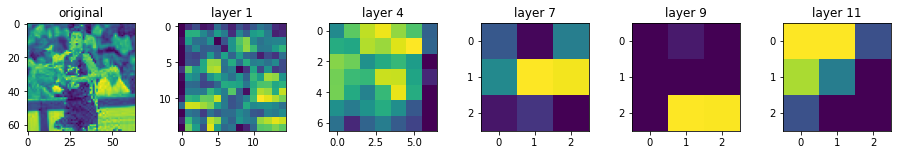

Epoch [20/50] | Test loss : 0.0230261057138443 | Test Accuracy : 10.0 %
Epoch [21/50] | Step [20/40] | Train Loss: 2.3006
Epoch [21/50] | Step [40/40] | Train Loss: 2.3033


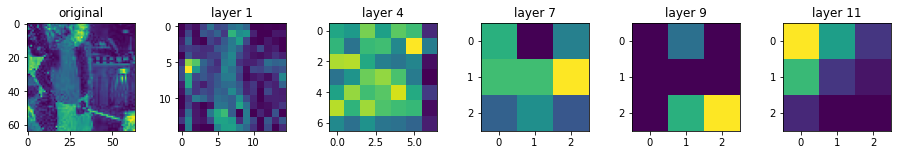

Epoch [21/50] | Test loss : 0.023026096701622006 | Test Accuracy : 10.0 %
Epoch [22/50] | Step [20/40] | Train Loss: 2.3029
Epoch [22/50] | Step [40/40] | Train Loss: 2.3029


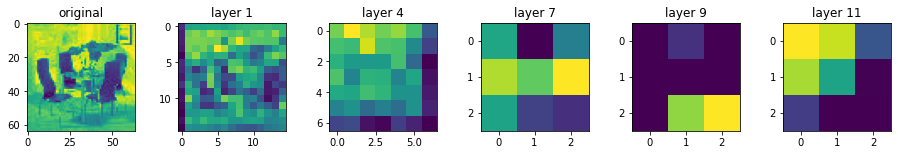

Epoch [22/50] | Test loss : 0.023026087951660154 | Test Accuracy : 10.0 %
Epoch [23/50] | Step [20/40] | Train Loss: 2.3026
Epoch [23/50] | Step [40/40] | Train Loss: 2.3028


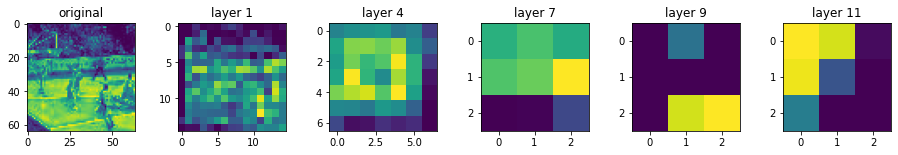

Epoch [23/50] | Test loss : 0.023026079440116885 | Test Accuracy : 10.0 %
Epoch [24/50] | Step [20/40] | Train Loss: 2.3038
Epoch [24/50] | Step [40/40] | Train Loss: 2.3035


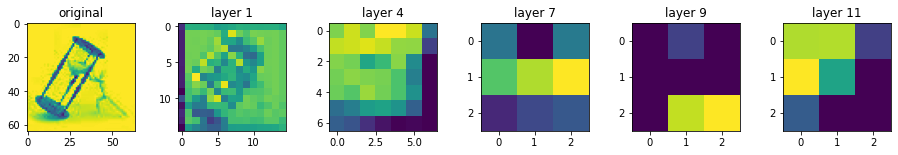

Epoch [24/50] | Test loss : 0.023026070809364318 | Test Accuracy : 10.0 %
Epoch [25/50] | Step [20/40] | Train Loss: 2.3027
Epoch [25/50] | Step [40/40] | Train Loss: 2.3023


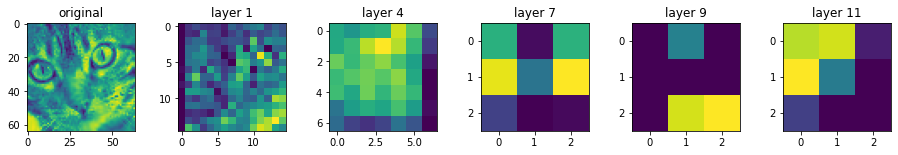

Epoch [25/50] | Test loss : 0.023026062774658206 | Test Accuracy : 10.0 %
Epoch [26/50] | Step [20/40] | Train Loss: 2.3032
Epoch [26/50] | Step [40/40] | Train Loss: 2.3019


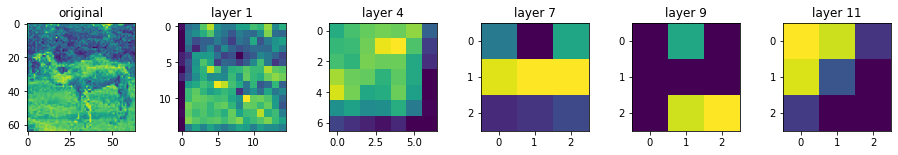

Epoch [26/50] | Test loss : 0.02302605457305908 | Test Accuracy : 10.0 %
Epoch [27/50] | Step [20/40] | Train Loss: 2.3033
Epoch [27/50] | Step [40/40] | Train Loss: 2.3024


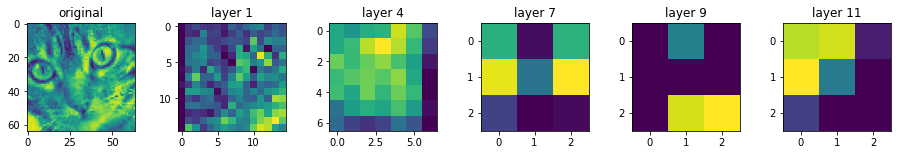

Epoch [27/50] | Test loss : 0.02302604665756226 | Test Accuracy : 10.0 %
Epoch [28/50] | Step [20/40] | Train Loss: 2.3030
Epoch [28/50] | Step [40/40] | Train Loss: 2.3029


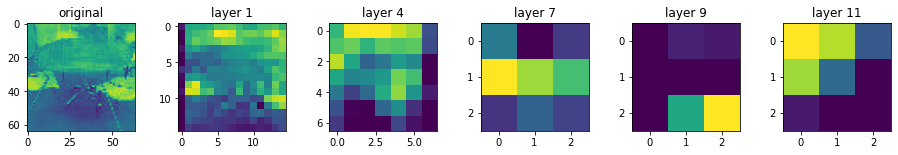

Epoch [28/50] | Test loss : 0.02302603840827942 | Test Accuracy : 10.0 %
Epoch [29/50] | Step [20/40] | Train Loss: 2.3025
Epoch [29/50] | Step [40/40] | Train Loss: 2.3018


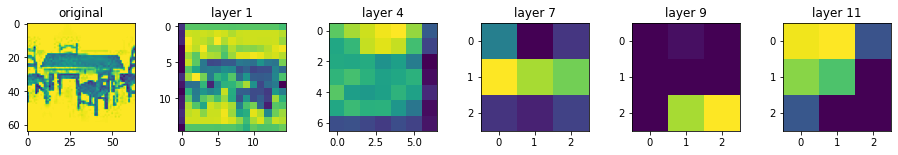

Epoch [29/50] | Test loss : 0.023026030254364015 | Test Accuracy : 10.0 %
Epoch [30/50] | Step [20/40] | Train Loss: 2.3021
Epoch [30/50] | Step [40/40] | Train Loss: 2.3042


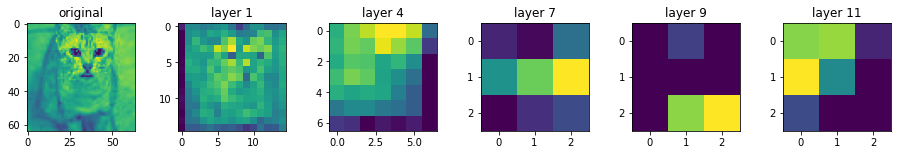

Epoch [30/50] | Test loss : 0.023026022410392758 | Test Accuracy : 10.0 %
Epoch [31/50] | Step [20/40] | Train Loss: 2.3025
Epoch [31/50] | Step [40/40] | Train Loss: 2.3019


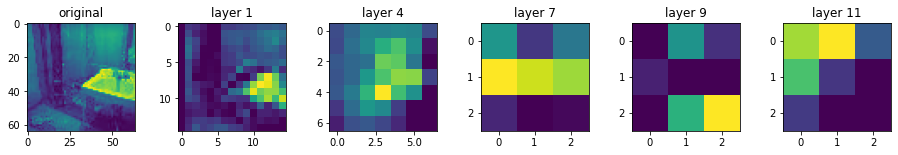

Epoch [31/50] | Test loss : 0.023026014447212216 | Test Accuracy : 10.0 %
Epoch [32/50] | Step [20/40] | Train Loss: 2.3017
Epoch [32/50] | Step [40/40] | Train Loss: 2.3014


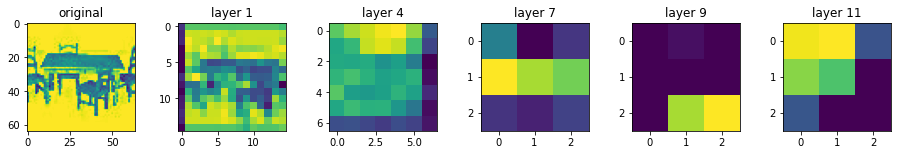

Epoch [32/50] | Test loss : 0.02302600655555725 | Test Accuracy : 10.0 %
Epoch [33/50] | Step [20/40] | Train Loss: 2.3031
Epoch [33/50] | Step [40/40] | Train Loss: 2.3022


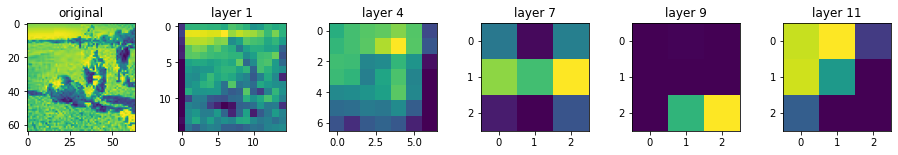

Epoch [33/50] | Test loss : 0.023025998759269712 | Test Accuracy : 10.0 %
Epoch [34/50] | Step [20/40] | Train Loss: 2.3013
Epoch [34/50] | Step [40/40] | Train Loss: 2.3027


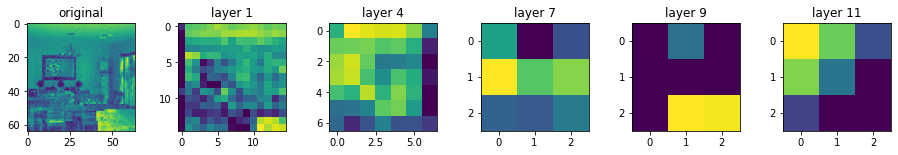

Epoch [34/50] | Test loss : 0.02302599101066589 | Test Accuracy : 10.0 %
Epoch [35/50] | Step [20/40] | Train Loss: 2.3029
Epoch [35/50] | Step [40/40] | Train Loss: 2.3026


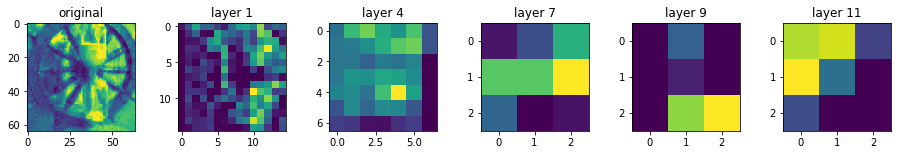

Epoch [35/50] | Test loss : 0.023025983524322512 | Test Accuracy : 10.0 %
Epoch [36/50] | Step [20/40] | Train Loss: 2.3021
Epoch [36/50] | Step [40/40] | Train Loss: 2.3026


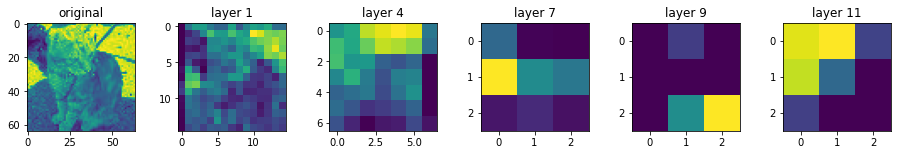

Epoch [36/50] | Test loss : 0.023025976252555848 | Test Accuracy : 10.0 %
Epoch [37/50] | Step [20/40] | Train Loss: 2.3032
Epoch [37/50] | Step [40/40] | Train Loss: 2.3015


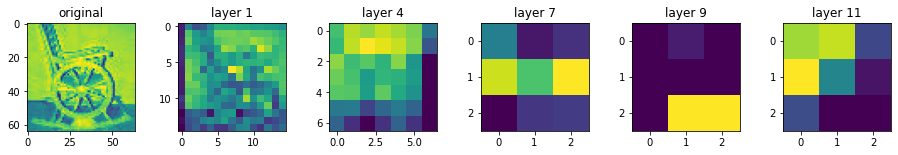

Epoch [37/50] | Test loss : 0.02302596893310547 | Test Accuracy : 10.0 %
Epoch [38/50] | Step [20/40] | Train Loss: 2.3029
Epoch [38/50] | Step [40/40] | Train Loss: 2.3022


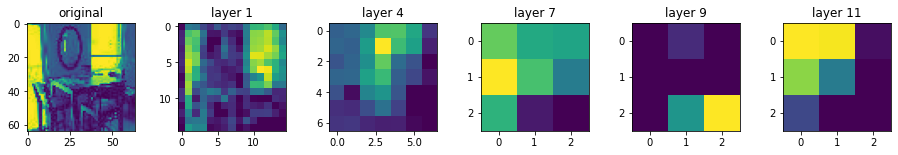

Epoch [38/50] | Test loss : 0.02302596209049225 | Test Accuracy : 10.0 %
Epoch [39/50] | Step [20/40] | Train Loss: 2.3027
Epoch [39/50] | Step [40/40] | Train Loss: 2.3014


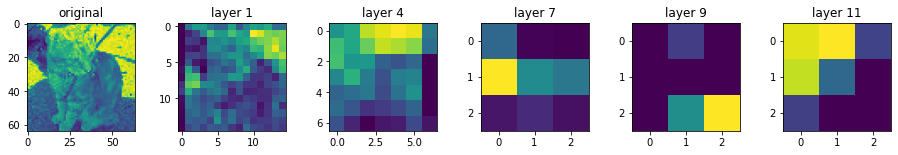

Epoch [39/50] | Test loss : 0.023025955200195312 | Test Accuracy : 10.0 %
Epoch [40/50] | Step [20/40] | Train Loss: 2.3039
Epoch [40/50] | Step [40/40] | Train Loss: 2.3030


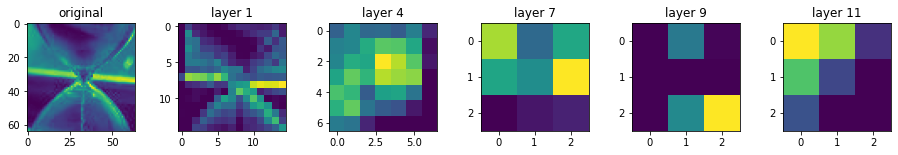

Epoch [40/50] | Test loss : 0.023025948333740234 | Test Accuracy : 10.0 %
Epoch [41/50] | Step [20/40] | Train Loss: 2.3030
Epoch [41/50] | Step [40/40] | Train Loss: 2.3031


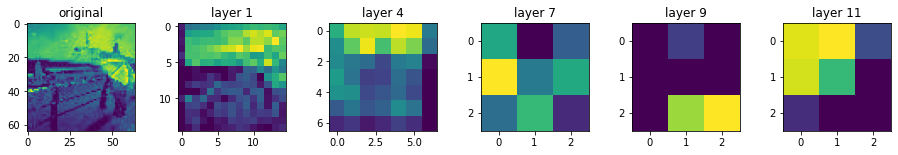

Epoch [41/50] | Test loss : 0.023025941157341006 | Test Accuracy : 10.0 %
Epoch [42/50] | Step [20/40] | Train Loss: 2.3023
Epoch [42/50] | Step [40/40] | Train Loss: 2.3024


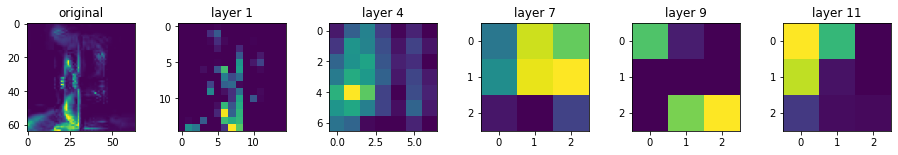

Epoch [42/50] | Test loss : 0.023025934505462645 | Test Accuracy : 10.0 %
Epoch [43/50] | Step [20/40] | Train Loss: 2.3033
Epoch [43/50] | Step [40/40] | Train Loss: 2.3027


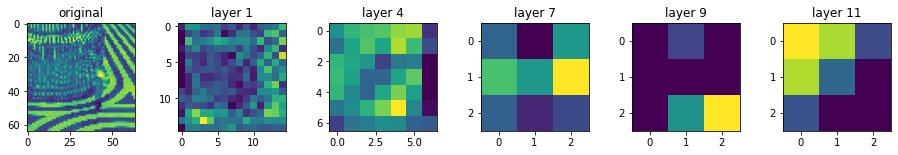

Epoch [43/50] | Test loss : 0.02302592782974243 | Test Accuracy : 10.0 %
Epoch [44/50] | Step [20/40] | Train Loss: 2.3019
Epoch [44/50] | Step [40/40] | Train Loss: 2.3012


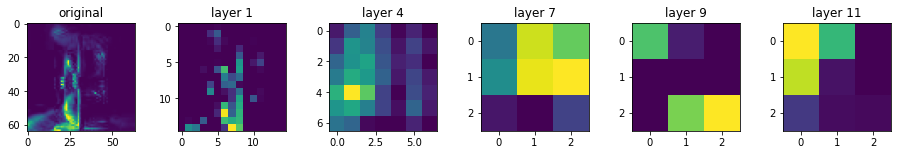

Epoch [44/50] | Test loss : 0.02302592108249664 | Test Accuracy : 10.0 %
Epoch [45/50] | Step [20/40] | Train Loss: 2.3032
Epoch [45/50] | Step [40/40] | Train Loss: 2.3024


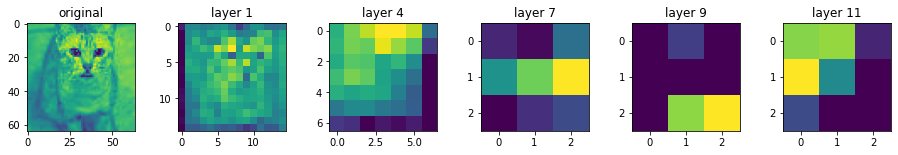

Epoch [45/50] | Test loss : 0.023025914430618286 | Test Accuracy : 10.0 %
Epoch [46/50] | Step [20/40] | Train Loss: 2.3022
Epoch [46/50] | Step [40/40] | Train Loss: 2.3023


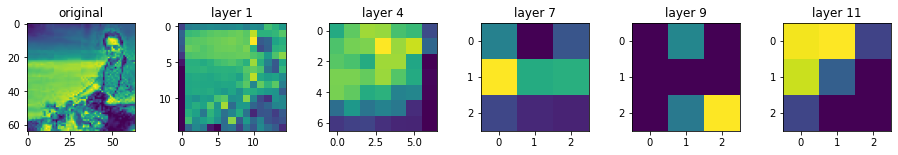

Epoch [46/50] | Test loss : 0.023025907778739932 | Test Accuracy : 10.0 %
Epoch [47/50] | Step [20/40] | Train Loss: 2.3017
Epoch [47/50] | Step [40/40] | Train Loss: 2.3035


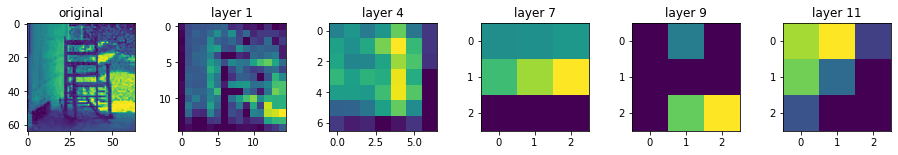

Epoch [47/50] | Test loss : 0.02302590112686157 | Test Accuracy : 10.0 %
Epoch [48/50] | Step [20/40] | Train Loss: 2.3028
Epoch [48/50] | Step [40/40] | Train Loss: 2.3035


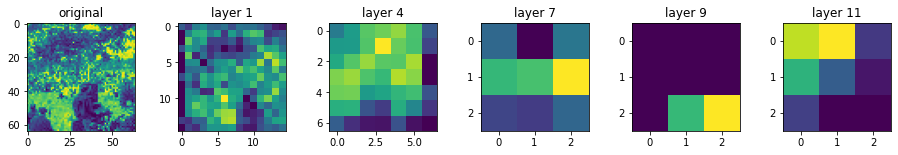

Epoch [48/50] | Test loss : 0.02302589461803436 | Test Accuracy : 10.0 %
Epoch [49/50] | Step [20/40] | Train Loss: 2.3025
Epoch [49/50] | Step [40/40] | Train Loss: 2.3034


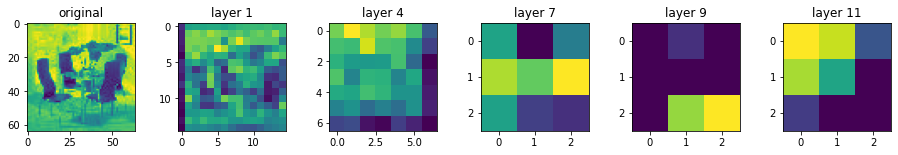

Epoch [49/50] | Test loss : 0.023025887918472293 | Test Accuracy : 10.0 %
Epoch [50/50] | Step [20/40] | Train Loss: 2.3034
Epoch [50/50] | Step [40/40] | Train Loss: 2.3015


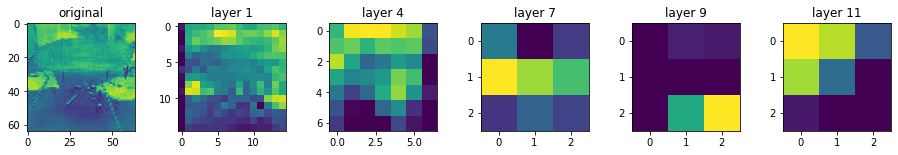

Epoch [50/50] | Test loss : 0.023025881505012512 | Test Accuracy : 10.0 %


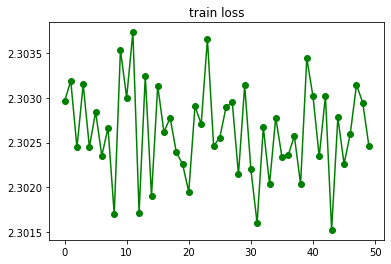

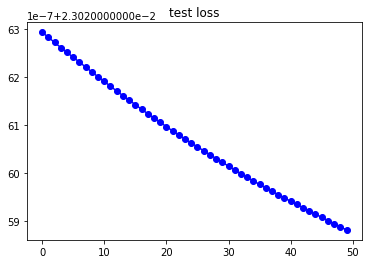

In [7]:
flattened_outputs_list1, original_labels_list1 = hw6q1train(loaders, alexnet_model, loss_func1, optimizer_sgd1, y_mapping, num_epochs, 'alexnet')

No handles with labels found to put in legend.


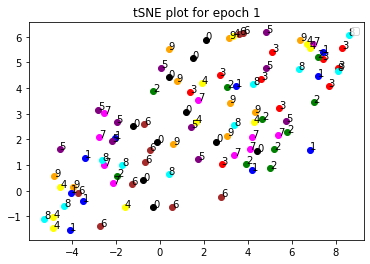

No handles with labels found to put in legend.


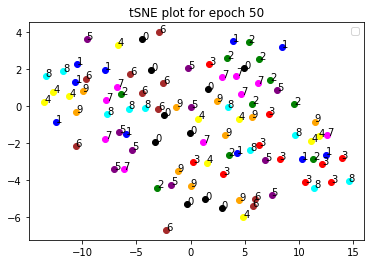

In [8]:
hw6q1TSNE(flattened_outputs_list1, original_labels_list1, num_epochs)

In [15]:
resnet50_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
#print(resnet50_model.eval())
resnet50_model.fc = nn.Linear(2048,10)
print(resnet50_model.eval())
"""for name, module in resnet50_model.named_modules():
    print(name, type(module))
for name, module in resnet50_model.named_modules():
    if isinstance(module, tuple([torch.nn.modules.container.Sequential])) or 'Bottleneck' in str(type(module)):
        print(name, True)
    else:
        print(name, False)
"""
loss_func2 = nn.CrossEntropyLoss()
optimizer_sgd2 = optim.SGD(resnet50_model.parameters(), lr = learning_rate, momentum = 0.0)
num_epochs = 50

Using cache found in C:\Users\sanyo/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

Epoch [1/50] | Step [20/40] | Train Loss: 2.3254
Epoch [1/50] | Step [40/40] | Train Loss: 2.3409


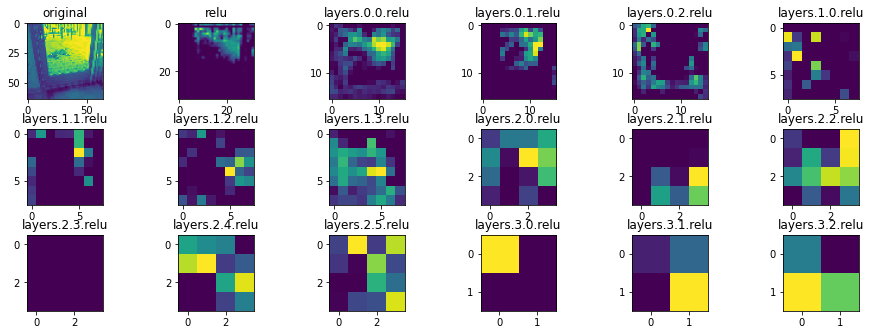

Epoch [1/50] | Test loss : 0.02364852452278137 | Test Accuracy : 7.000000000000001 %
Epoch [2/50] | Step [20/40] | Train Loss: 2.3483
Epoch [2/50] | Step [40/40] | Train Loss: 2.3647


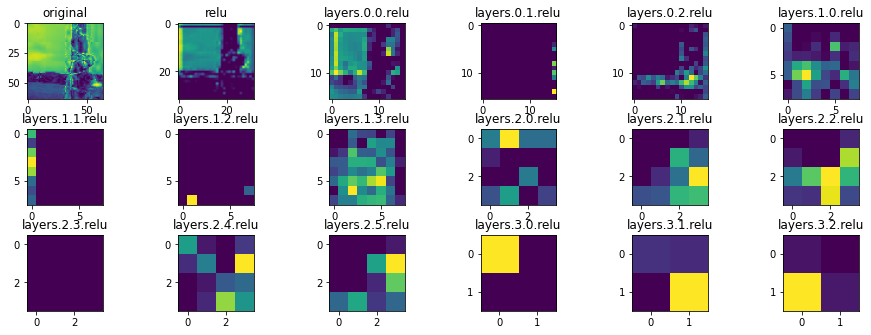

Epoch [2/50] | Test loss : 0.029212393549829723 | Test Accuracy : 10.0 %
Epoch [3/50] | Step [20/40] | Train Loss: 2.3964
Epoch [3/50] | Step [40/40] | Train Loss: 2.3574


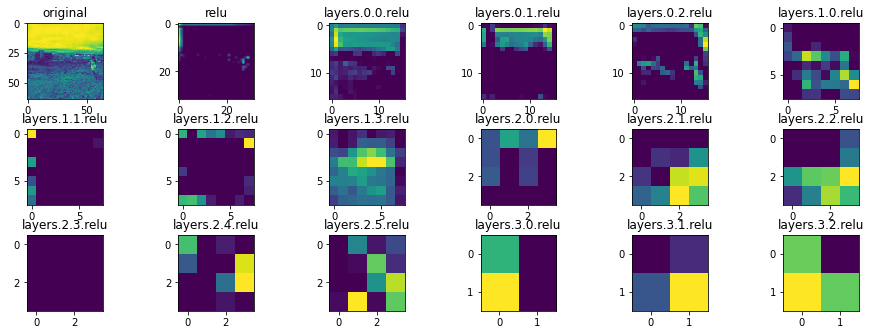

Epoch [3/50] | Test loss : 0.023577272605895996 | Test Accuracy : 11.0 %
Epoch [4/50] | Step [20/40] | Train Loss: 2.4056
Epoch [4/50] | Step [40/40] | Train Loss: 2.3799


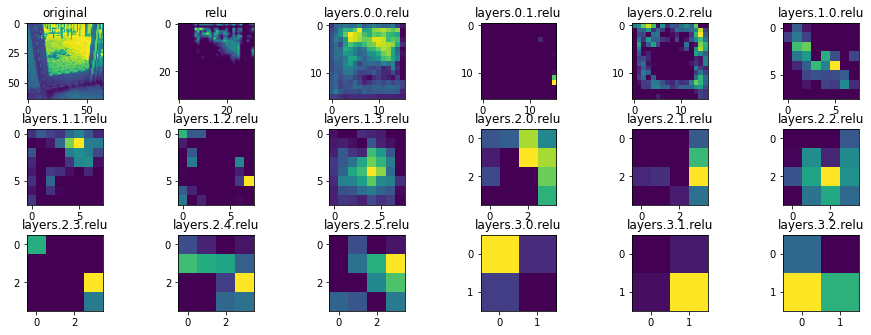

Epoch [4/50] | Test loss : 0.023405330312252046 | Test Accuracy : 12.0 %
Epoch [5/50] | Step [20/40] | Train Loss: 2.3761
Epoch [5/50] | Step [40/40] | Train Loss: 2.3213


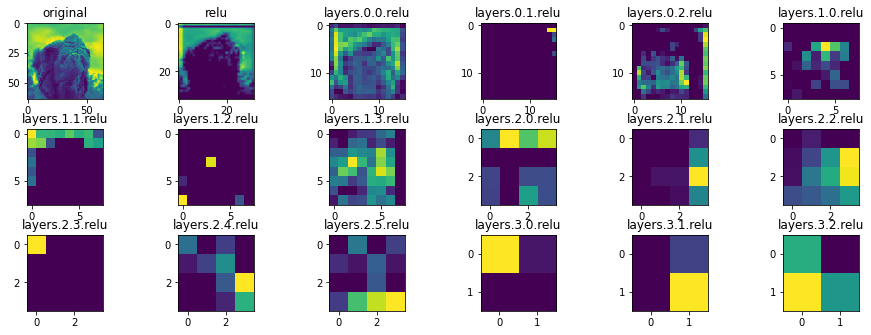

Epoch [5/50] | Test loss : 0.023400686532258987 | Test Accuracy : 14.000000000000002 %
Epoch [6/50] | Step [20/40] | Train Loss: 2.3362
Epoch [6/50] | Step [40/40] | Train Loss: 2.3746


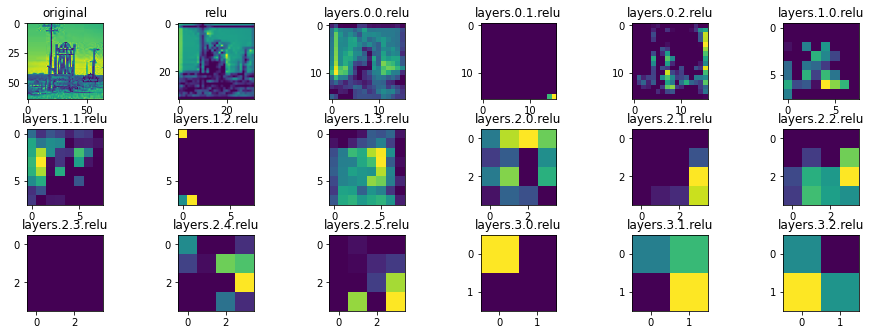

Epoch [6/50] | Test loss : 0.023155051529407503 | Test Accuracy : 14.000000000000002 %
Epoch [7/50] | Step [20/40] | Train Loss: 2.3720
Epoch [7/50] | Step [40/40] | Train Loss: 2.3988


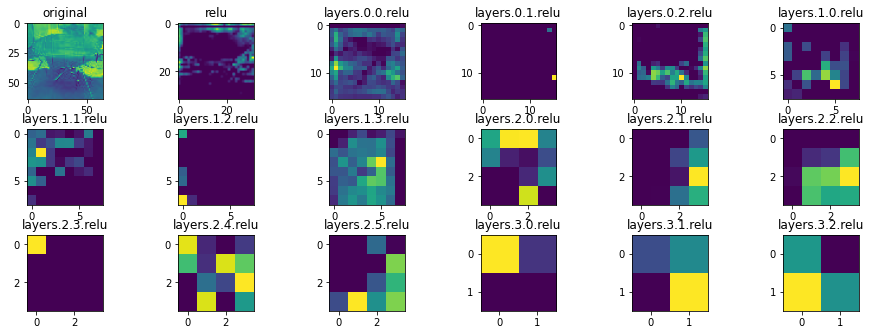

Epoch [7/50] | Test loss : 0.0224867435336113 | Test Accuracy : 16.0 %
Epoch [8/50] | Step [20/40] | Train Loss: 2.3320
Epoch [8/50] | Step [40/40] | Train Loss: 2.3647


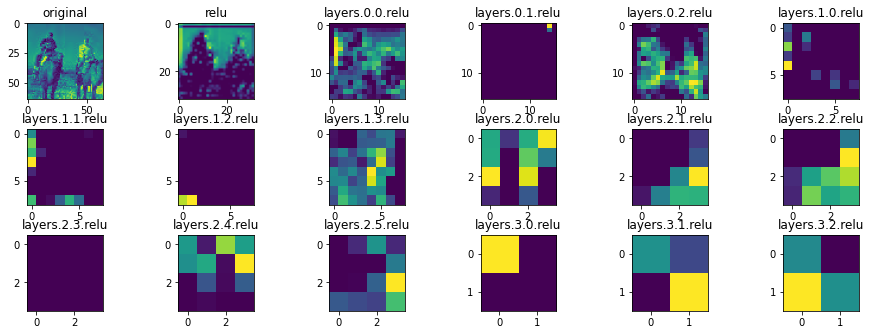

Epoch [8/50] | Test loss : 0.022975083637237548 | Test Accuracy : 10.0 %
Epoch [9/50] | Step [20/40] | Train Loss: 2.2534
Epoch [9/50] | Step [40/40] | Train Loss: 2.3131


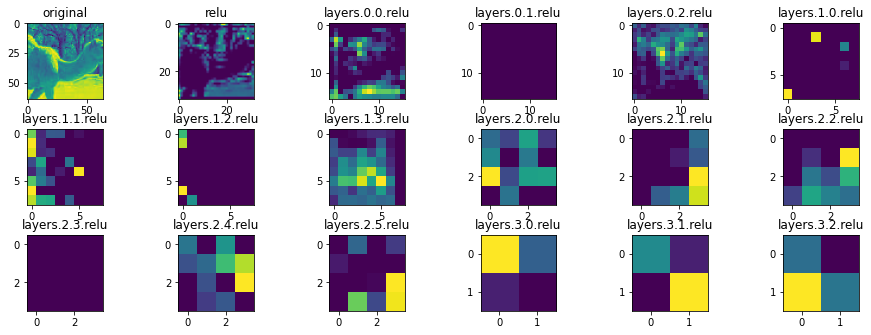

Epoch [9/50] | Test loss : 0.02238507732152939 | Test Accuracy : 19.0 %
Epoch [10/50] | Step [20/40] | Train Loss: 2.3761
Epoch [10/50] | Step [40/40] | Train Loss: 2.4097


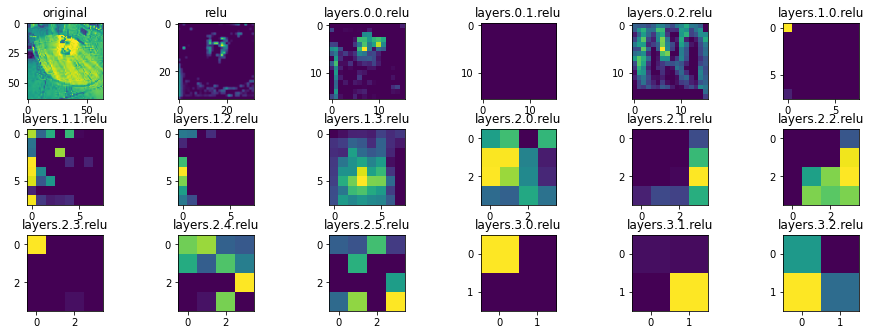

Epoch [10/50] | Test loss : 0.024821905702352525 | Test Accuracy : 19.0 %
Epoch [11/50] | Step [20/40] | Train Loss: 2.3943
Epoch [11/50] | Step [40/40] | Train Loss: 2.3041


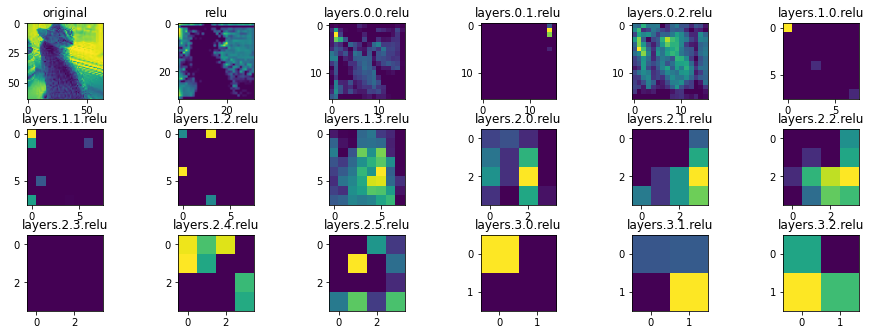

Epoch [11/50] | Test loss : 0.022346578097343445 | Test Accuracy : 17.0 %
Epoch [12/50] | Step [20/40] | Train Loss: 2.3608
Epoch [12/50] | Step [40/40] | Train Loss: 2.2472


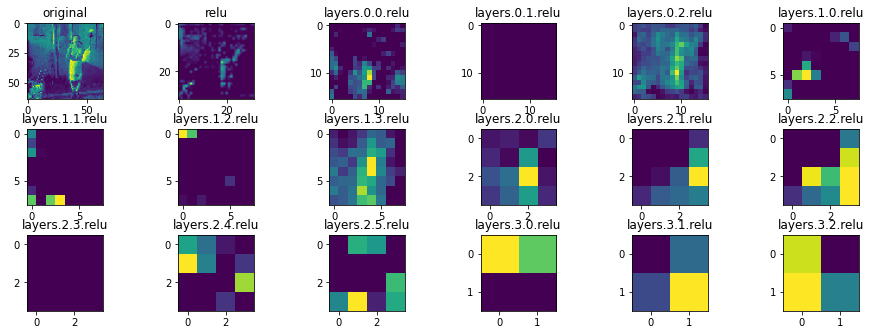

Epoch [12/50] | Test loss : 0.022822349905967713 | Test Accuracy : 15.0 %
Epoch [13/50] | Step [20/40] | Train Loss: 2.2007
Epoch [13/50] | Step [40/40] | Train Loss: 2.2500


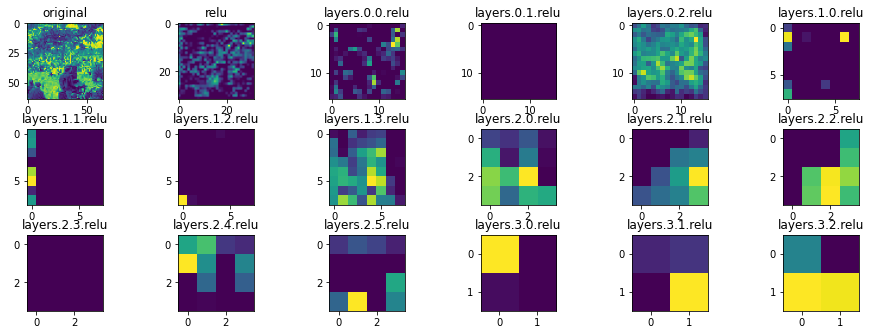

Epoch [13/50] | Test loss : 0.022108147847652436 | Test Accuracy : 20.0 %
Epoch [14/50] | Step [20/40] | Train Loss: 2.3086
Epoch [14/50] | Step [40/40] | Train Loss: 2.1805


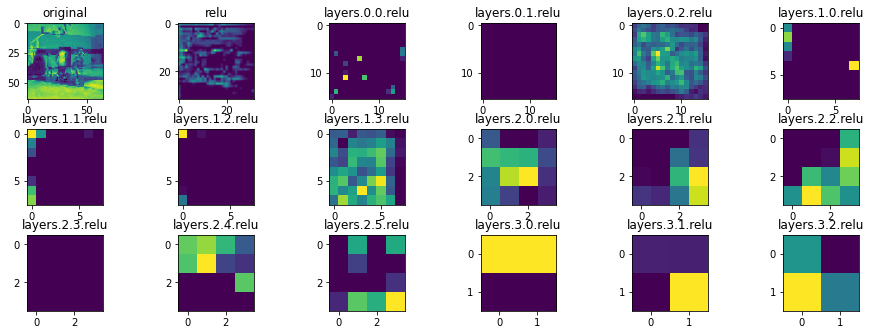

Epoch [14/50] | Test loss : 0.022602826106548308 | Test Accuracy : 19.0 %
Epoch [15/50] | Step [20/40] | Train Loss: 2.2992
Epoch [15/50] | Step [40/40] | Train Loss: 2.2670


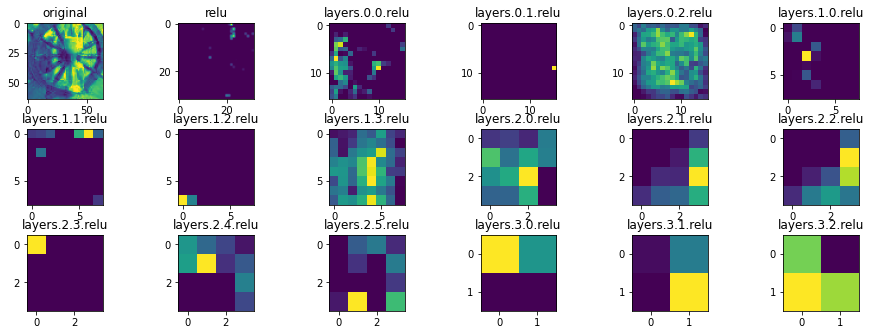

Epoch [15/50] | Test loss : 0.021993881833553313 | Test Accuracy : 10.0 %
Epoch [16/50] | Step [20/40] | Train Loss: 2.3143
Epoch [16/50] | Step [40/40] | Train Loss: 2.3133


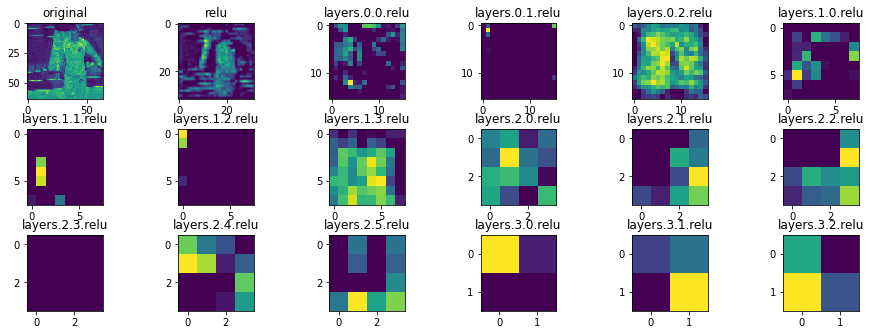

Epoch [16/50] | Test loss : 0.021743893778324128 | Test Accuracy : 18.0 %
Epoch [17/50] | Step [20/40] | Train Loss: 2.2961
Epoch [17/50] | Step [40/40] | Train Loss: 2.1908


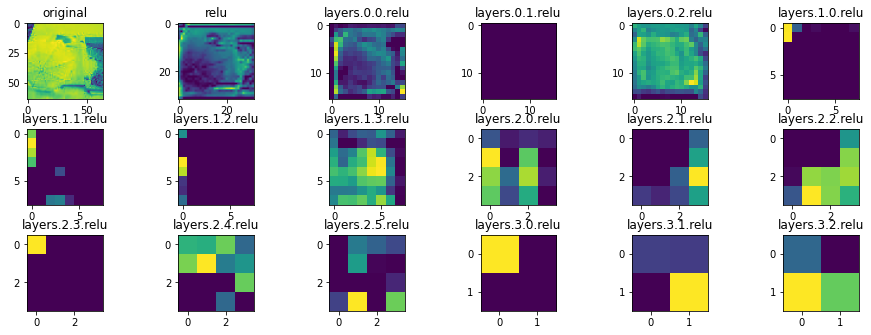

Epoch [17/50] | Test loss : 0.02275848854184151 | Test Accuracy : 18.0 %
Epoch [18/50] | Step [20/40] | Train Loss: 2.2465
Epoch [18/50] | Step [40/40] | Train Loss: 2.2305


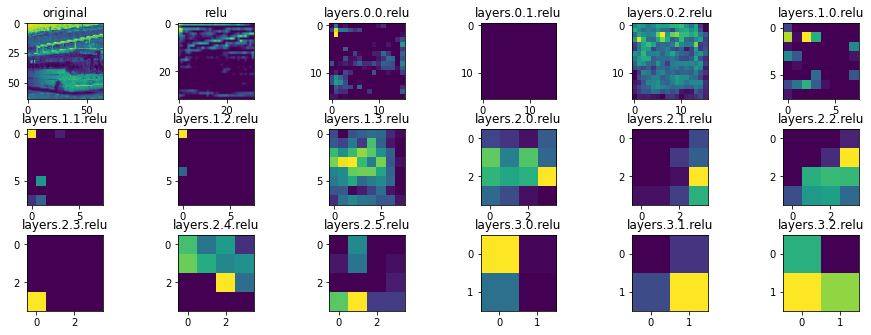

Epoch [18/50] | Test loss : 0.021511387813091275 | Test Accuracy : 22.0 %
Epoch [19/50] | Step [20/40] | Train Loss: 2.2278
Epoch [19/50] | Step [40/40] | Train Loss: 2.2522


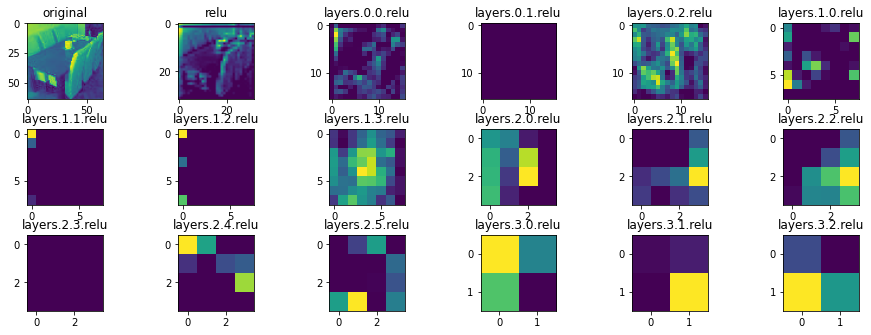

Epoch [19/50] | Test loss : 0.021433805841207507 | Test Accuracy : 18.0 %
Epoch [20/50] | Step [20/40] | Train Loss: 2.1919
Epoch [20/50] | Step [40/40] | Train Loss: 2.1465


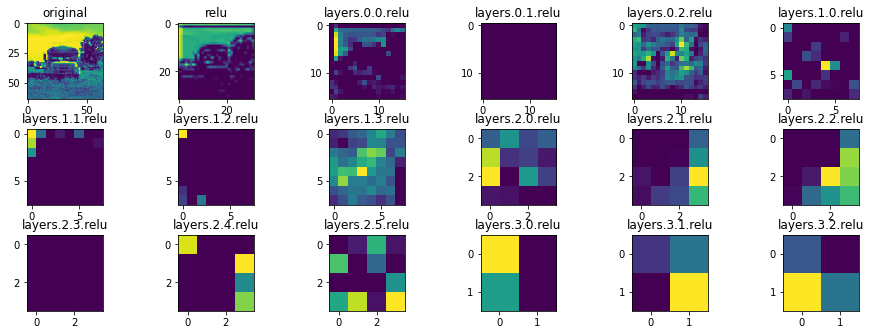

Epoch [20/50] | Test loss : 0.021694089937210084 | Test Accuracy : 23.0 %
Epoch [21/50] | Step [20/40] | Train Loss: 2.2306
Epoch [21/50] | Step [40/40] | Train Loss: 2.2056


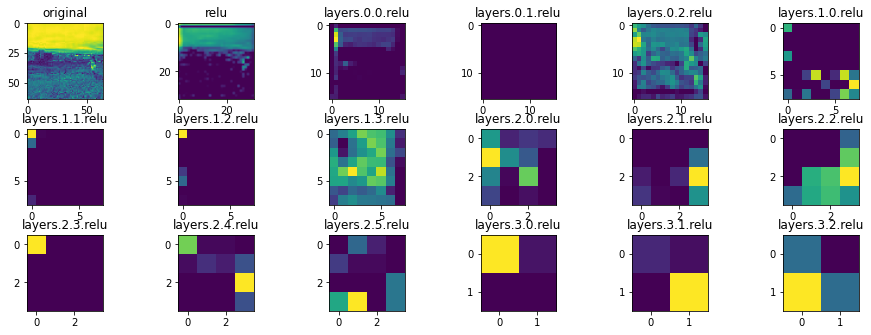

Epoch [21/50] | Test loss : 0.021474446880817413 | Test Accuracy : 20.0 %
Epoch [22/50] | Step [20/40] | Train Loss: 2.1587
Epoch [22/50] | Step [40/40] | Train Loss: 2.1336


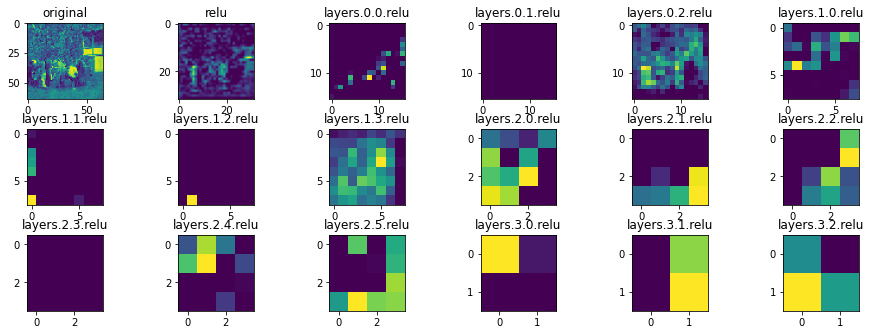

Epoch [22/50] | Test loss : 0.022001104271411897 | Test Accuracy : 19.0 %
Epoch [23/50] | Step [20/40] | Train Loss: 2.1268
Epoch [23/50] | Step [40/40] | Train Loss: 2.1450


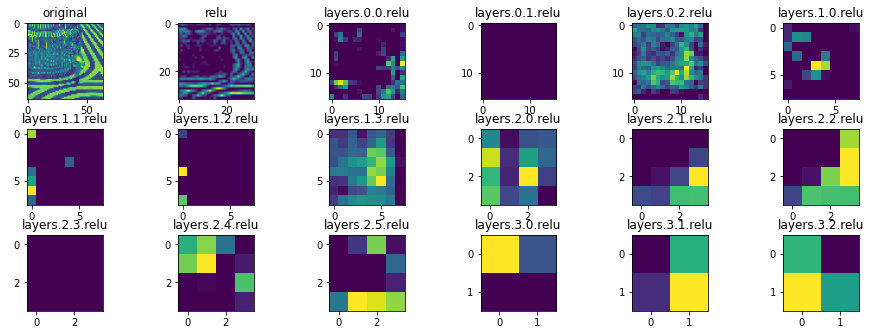

Epoch [23/50] | Test loss : 0.020721470922231675 | Test Accuracy : 22.0 %
Epoch [24/50] | Step [20/40] | Train Loss: 2.1904
Epoch [24/50] | Step [40/40] | Train Loss: 2.1202


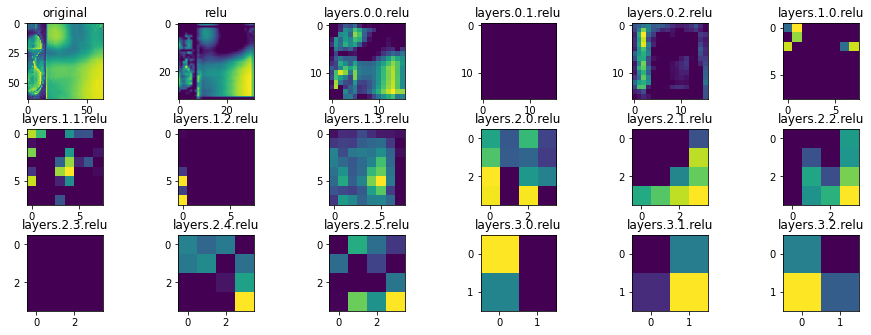

Epoch [24/50] | Test loss : 0.02062159066796303 | Test Accuracy : 27.0 %
Epoch [25/50] | Step [20/40] | Train Loss: 2.1011
Epoch [25/50] | Step [40/40] | Train Loss: 2.0365


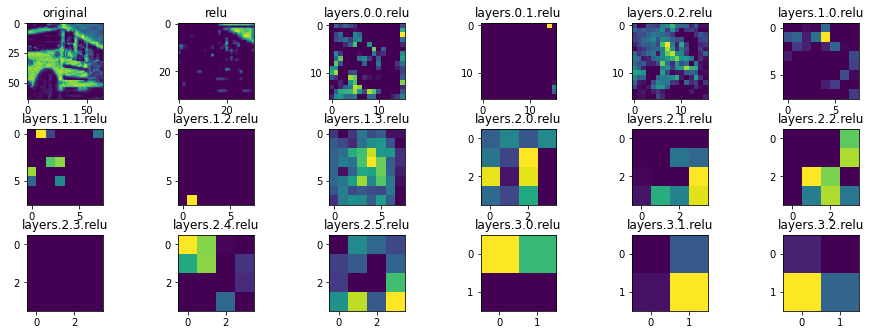

Epoch [25/50] | Test loss : 0.020682969743013382 | Test Accuracy : 27.0 %
Epoch [26/50] | Step [20/40] | Train Loss: 2.2037
Epoch [26/50] | Step [40/40] | Train Loss: 2.2639


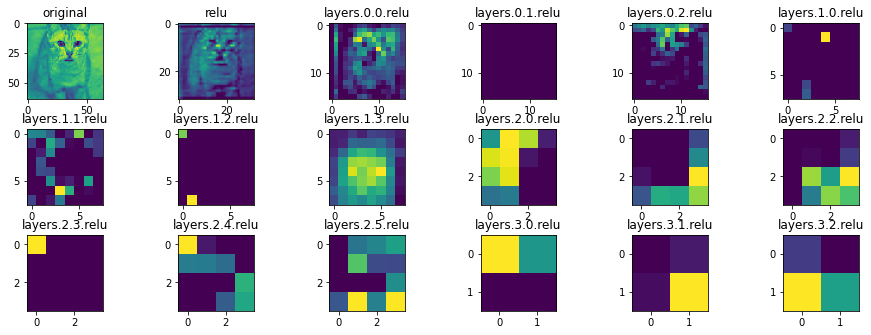

Epoch [26/50] | Test loss : 0.019986291635036468 | Test Accuracy : 28.999999999999996 %
Epoch [27/50] | Step [20/40] | Train Loss: 2.1248
Epoch [27/50] | Step [40/40] | Train Loss: 2.1592


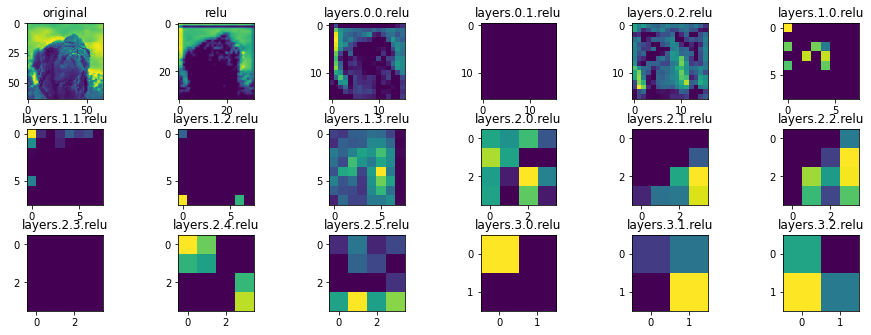

Epoch [27/50] | Test loss : 0.02026496195495129 | Test Accuracy : 28.000000000000004 %
Epoch [28/50] | Step [20/40] | Train Loss: 2.1472
Epoch [28/50] | Step [40/40] | Train Loss: 2.1426


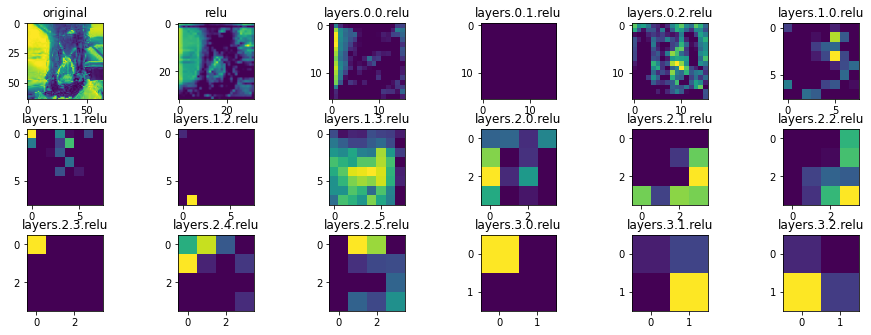

Epoch [28/50] | Test loss : 0.019731520718336105 | Test Accuracy : 37.0 %
Epoch [29/50] | Step [20/40] | Train Loss: 2.1199
Epoch [29/50] | Step [40/40] | Train Loss: 1.9796


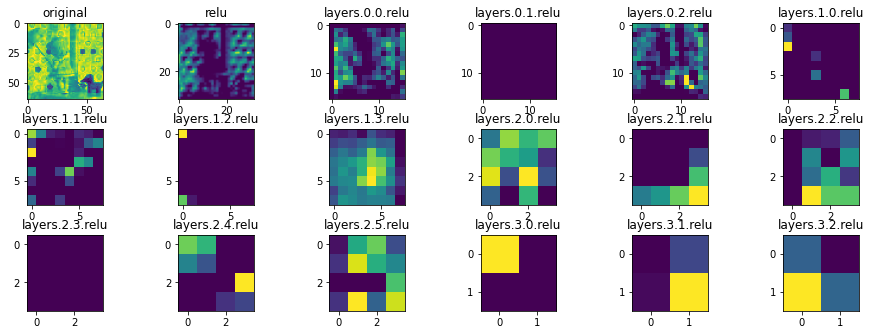

Epoch [29/50] | Test loss : 0.02123038032948971 | Test Accuracy : 19.0 %
Epoch [30/50] | Step [20/40] | Train Loss: 2.1174
Epoch [30/50] | Step [40/40] | Train Loss: 2.1103


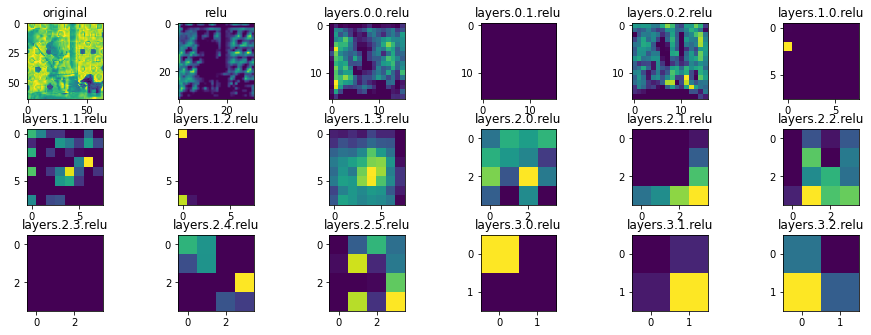

Epoch [30/50] | Test loss : 0.020289808350801467 | Test Accuracy : 28.999999999999996 %
Epoch [31/50] | Step [20/40] | Train Loss: 1.9764
Epoch [31/50] | Step [40/40] | Train Loss: 2.1311


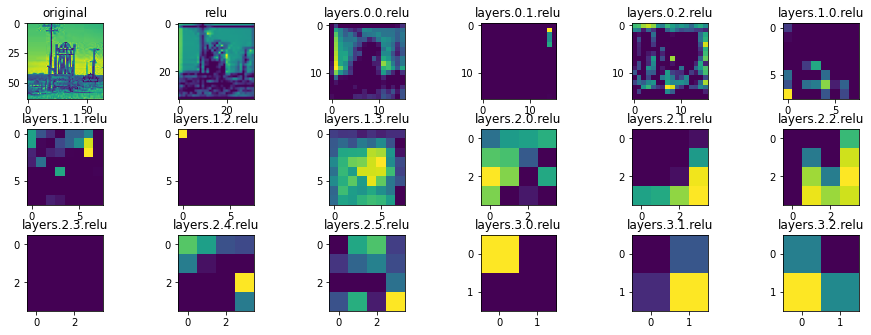

Epoch [31/50] | Test loss : 0.019140120369195938 | Test Accuracy : 35.0 %
Epoch [32/50] | Step [20/40] | Train Loss: 2.0692
Epoch [32/50] | Step [40/40] | Train Loss: 2.0833


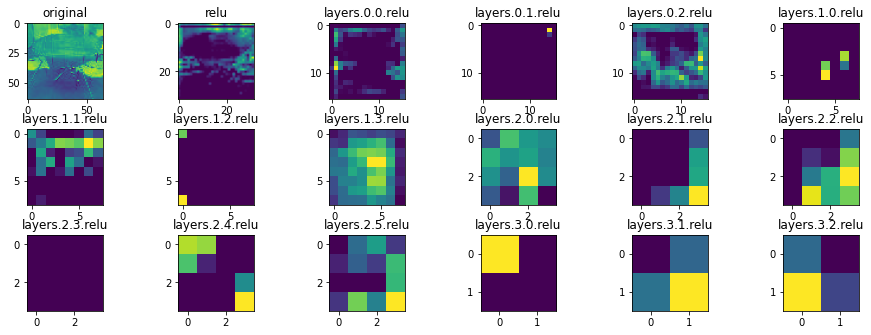

Epoch [32/50] | Test loss : 0.019938715744018554 | Test Accuracy : 24.0 %
Epoch [33/50] | Step [20/40] | Train Loss: 2.1042
Epoch [33/50] | Step [40/40] | Train Loss: 2.0896


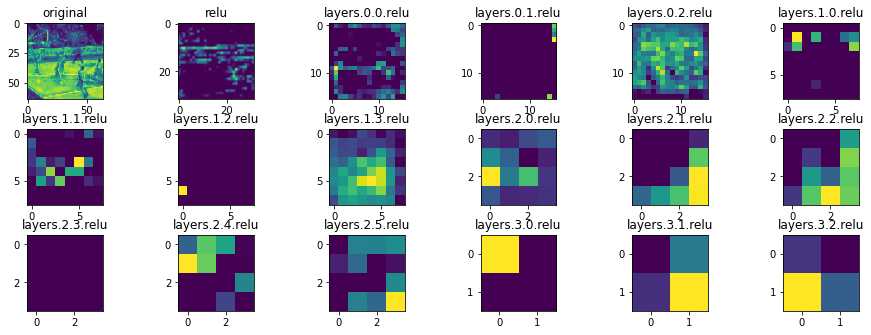

Epoch [33/50] | Test loss : 0.019441606992483138 | Test Accuracy : 27.0 %
Epoch [34/50] | Step [20/40] | Train Loss: 2.0496
Epoch [34/50] | Step [40/40] | Train Loss: 2.0293


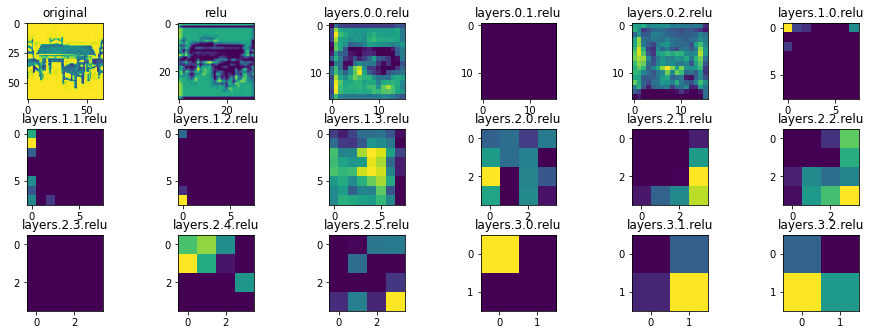

Epoch [34/50] | Test loss : 0.019021320882439616 | Test Accuracy : 32.0 %
Epoch [35/50] | Step [20/40] | Train Loss: 2.1673
Epoch [35/50] | Step [40/40] | Train Loss: 1.9830


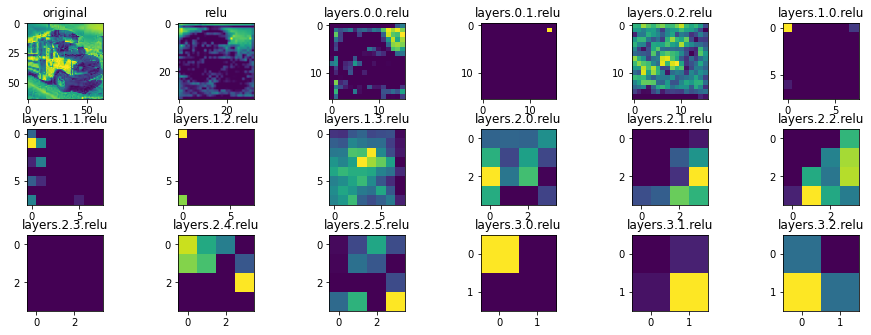

Epoch [35/50] | Test loss : 0.019309064025431873 | Test Accuracy : 24.0 %
Epoch [36/50] | Step [20/40] | Train Loss: 2.0161
Epoch [36/50] | Step [40/40] | Train Loss: 1.9790


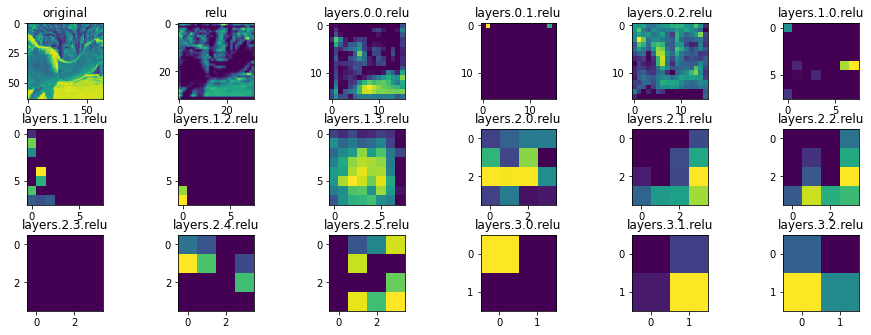

Epoch [36/50] | Test loss : 0.019129642337560652 | Test Accuracy : 28.999999999999996 %
Epoch [37/50] | Step [20/40] | Train Loss: 2.0707
Epoch [37/50] | Step [40/40] | Train Loss: 1.9769


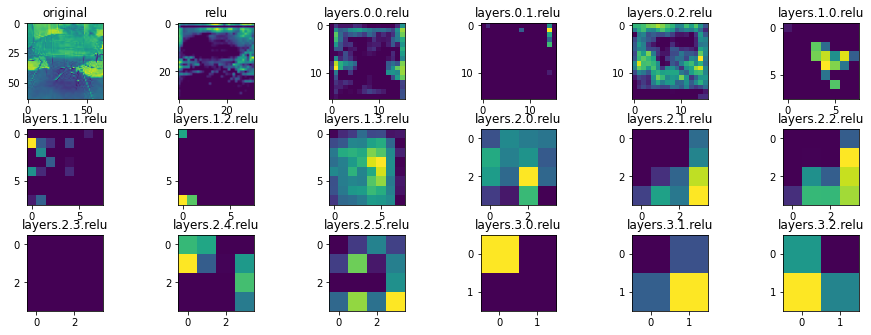

Epoch [37/50] | Test loss : 0.018978650603443382 | Test Accuracy : 28.000000000000004 %
Epoch [38/50] | Step [20/40] | Train Loss: 2.0046
Epoch [38/50] | Step [40/40] | Train Loss: 1.9813


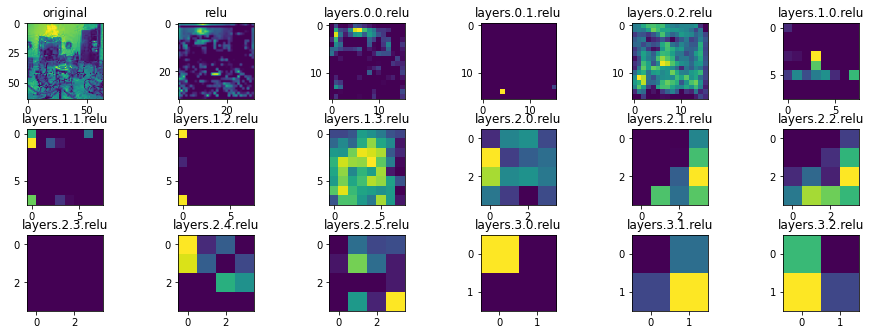

Epoch [38/50] | Test loss : 0.01825074219703674 | Test Accuracy : 35.0 %
Epoch [39/50] | Step [20/40] | Train Loss: 1.9181
Epoch [39/50] | Step [40/40] | Train Loss: 2.0575


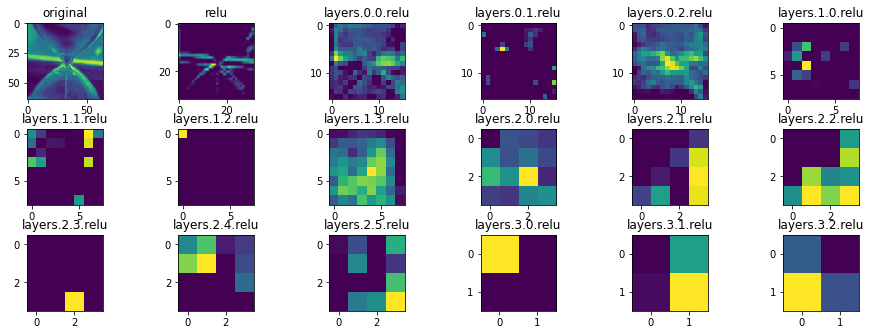

Epoch [39/50] | Test loss : 0.017981914085149767 | Test Accuracy : 28.000000000000004 %
Epoch [40/50] | Step [20/40] | Train Loss: 1.9448
Epoch [40/50] | Step [40/40] | Train Loss: 1.8381


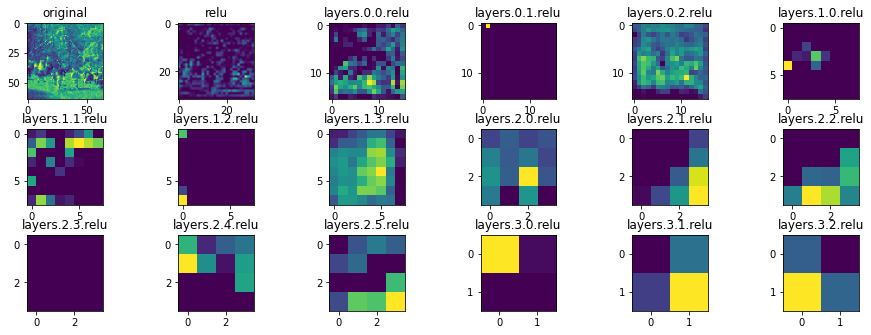

Epoch [40/50] | Test loss : 0.018260730788484215 | Test Accuracy : 37.0 %
Epoch [41/50] | Step [20/40] | Train Loss: 1.9664
Epoch [41/50] | Step [40/40] | Train Loss: 2.0089


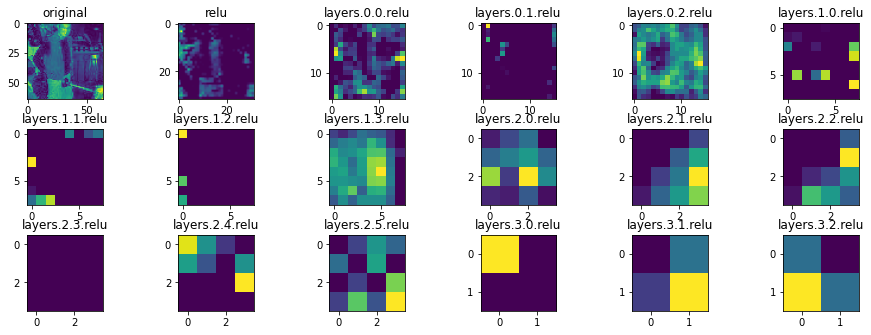

Epoch [41/50] | Test loss : 0.01772828612178564 | Test Accuracy : 40.0 %
Epoch [42/50] | Step [20/40] | Train Loss: 2.0352
Epoch [42/50] | Step [40/40] | Train Loss: 1.9677


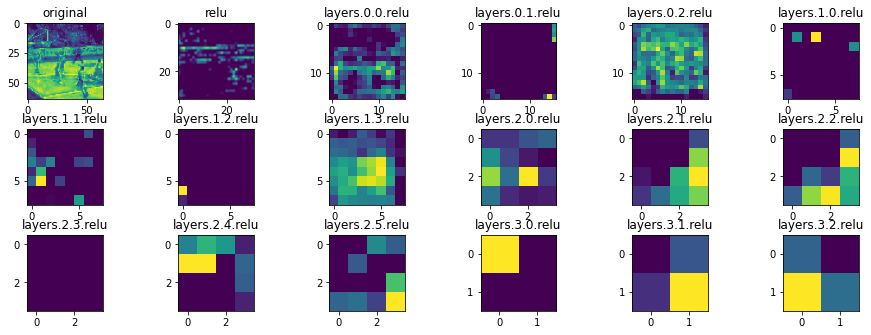

Epoch [42/50] | Test loss : 0.017942850190401077 | Test Accuracy : 34.0 %
Epoch [43/50] | Step [20/40] | Train Loss: 1.9372
Epoch [43/50] | Step [40/40] | Train Loss: 1.9947


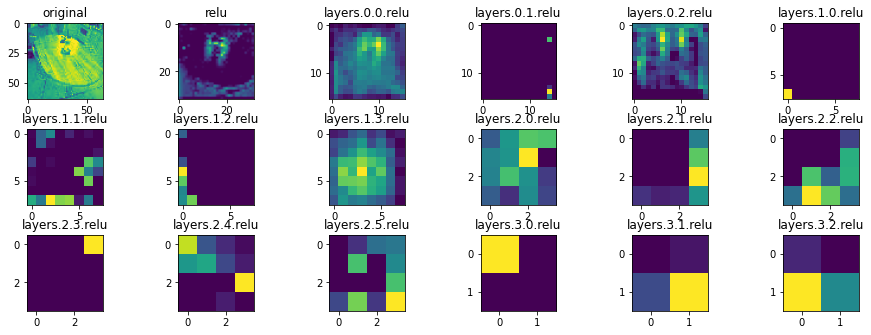

Epoch [43/50] | Test loss : 0.017638181605935097 | Test Accuracy : 34.0 %
Epoch [44/50] | Step [20/40] | Train Loss: 1.8840
Epoch [44/50] | Step [40/40] | Train Loss: 2.0451


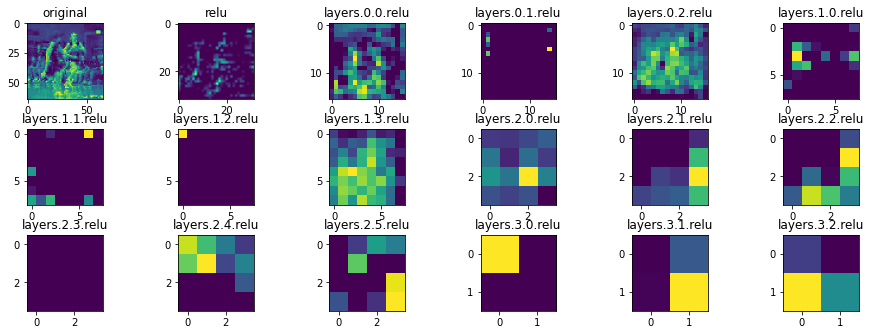

Epoch [44/50] | Test loss : 0.017214651917666197 | Test Accuracy : 33.0 %
Epoch [45/50] | Step [20/40] | Train Loss: 1.9133
Epoch [45/50] | Step [40/40] | Train Loss: 1.8799


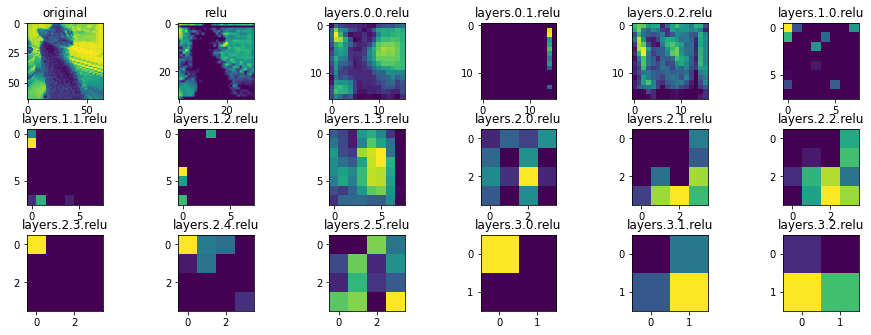

Epoch [45/50] | Test loss : 0.01739049151428044 | Test Accuracy : 38.0 %
Epoch [46/50] | Step [20/40] | Train Loss: 1.6189
Epoch [46/50] | Step [40/40] | Train Loss: 1.8649


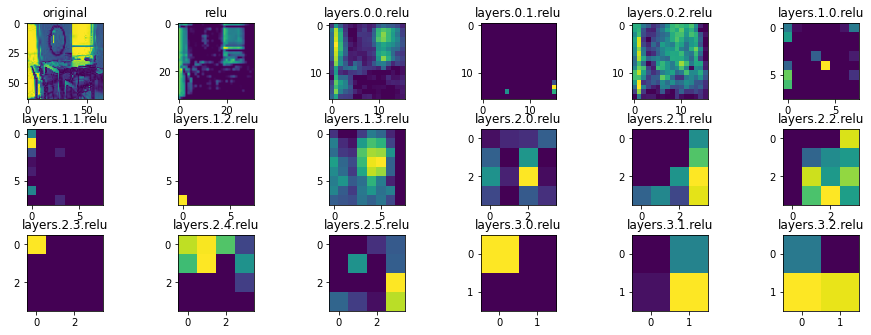

Epoch [46/50] | Test loss : 0.017358630225807428 | Test Accuracy : 36.0 %
Epoch [47/50] | Step [20/40] | Train Loss: 1.8521
Epoch [47/50] | Step [40/40] | Train Loss: 1.8074


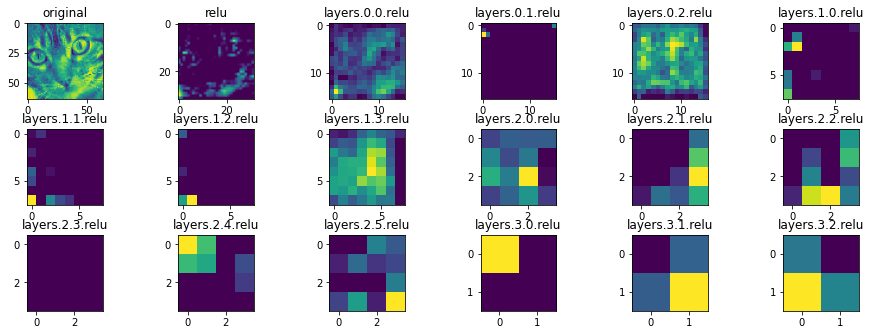

Epoch [47/50] | Test loss : 0.018191135715146082 | Test Accuracy : 35.0 %
Epoch [48/50] | Step [20/40] | Train Loss: 1.7195
Epoch [48/50] | Step [40/40] | Train Loss: 1.9683


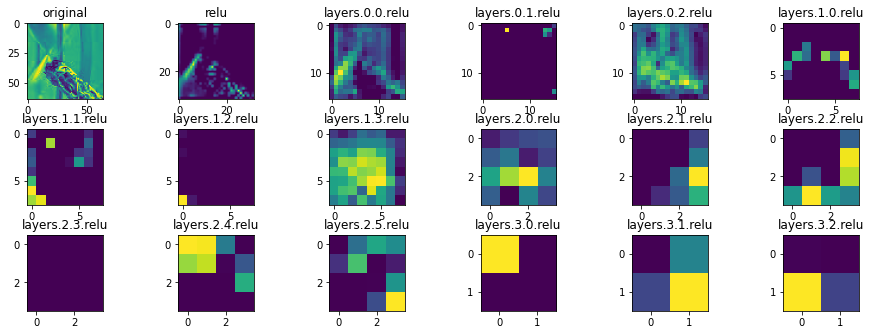

Epoch [48/50] | Test loss : 0.01687946947561577 | Test Accuracy : 39.0 %
Epoch [49/50] | Step [20/40] | Train Loss: 1.7961
Epoch [49/50] | Step [40/40] | Train Loss: 1.8128


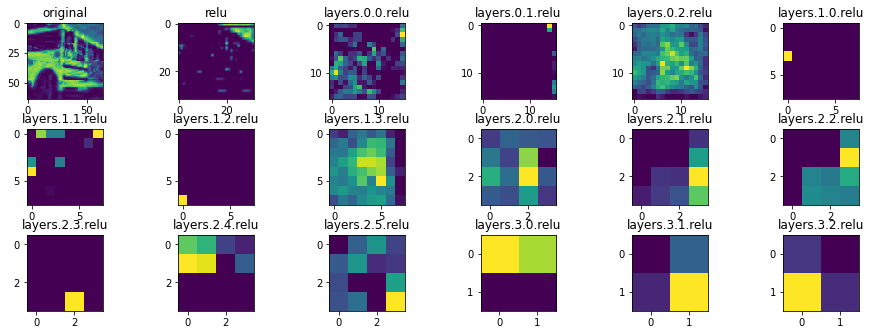

Epoch [49/50] | Test loss : 0.016934284489951098 | Test Accuracy : 36.0 %
Epoch [50/50] | Step [20/40] | Train Loss: 1.8457
Epoch [50/50] | Step [40/40] | Train Loss: 1.9610


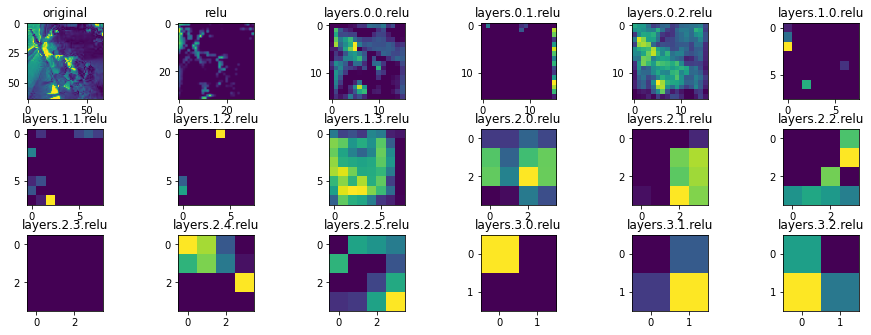

Epoch [50/50] | Test loss : 0.01792518123202026 | Test Accuracy : 34.0 %


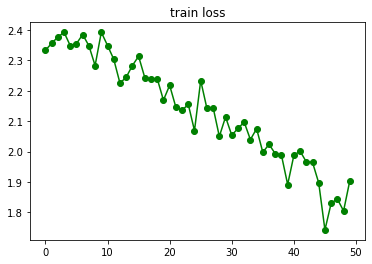

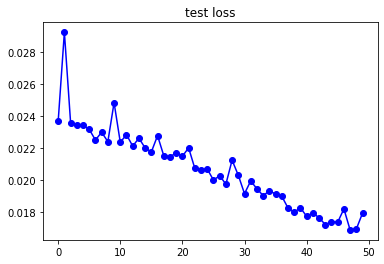

No handles with labels found to put in legend.


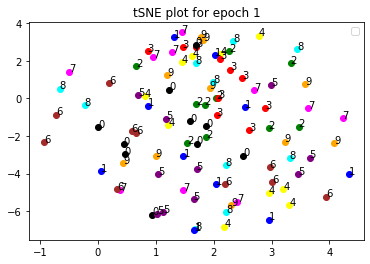

No handles with labels found to put in legend.


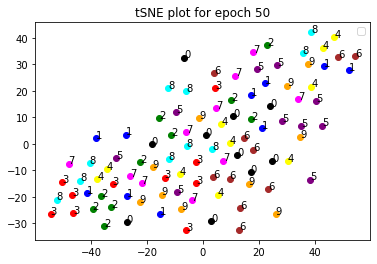

In [17]:
flattened_outputs_list2, original_labels_list2 = hw6q1train(loaders, resnet50_model, loss_func2, optimizer_sgd2, y_mapping, num_epochs, 'resnet50')
hw6q1TSNE(flattened_outputs_list2, original_labels_list2, num_epochs)

In [19]:
def findFiles(path): 
    return glob.glob(path)

#print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
#print(unicodeToAscii('Ślusàrski'))

all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

dataset = list()

def lineToTensor(line, all_letters):
    line_array = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        line_array[idx, 0, all_letters.find(letter)] = 1
    return line_array

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for line in lines:
        line_array = lineToTensor(line, all_letters)
        dataset.append(tuple([line_array, len(all_categories) - 1]))

n_categories = len(all_categories)
print(all_categories)

np.random.shuffle(dataset)

label_dataset = list()

for i in range(len(dataset)):
    label_dataset.append(dataset[i][1])

test_data_per_class = 20
test_dataset = list()
train_dataset = list()

for j in range(n_categories):
    indices = np.where(np.array(label_dataset) == j)[0]
    i = 0
    while i < len(indices):
        if i < test_data_per_class:
            test_dataset.append(dataset[indices[i]])
        else:
            train_dataset.append(dataset[indices[i]])
        i += 1

print("length of test_dataset :", len(test_dataset))
np.random.shuffle(test_dataset)
print("length of train_dataset :", len(train_dataset))
np.random.shuffle(train_dataset)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
length of test_dataset : 360
length of train_dataset : 19714


In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        #print(output.shape)
        output = self.relu(output)
        #print(output.shape)
        output = self.fc(output)
        #print(output.shape)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.relu(output)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

In [12]:
def categoryFromOutput(output, all_categories):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def hw6q2evaluate(test_dataset, model, loss_func, all_categories, model_name):
    # Test the model
    model.eval()
    confusion = torch.zeros(len(all_categories), len(all_categories))
    
    original_labels = list()
    with torch.no_grad():
        total_loss = 0.0
        accuracy = 0.0
        for i in range(len(test_dataset)):
            hidden = model.initHidden()
            label = test_dataset[i][1]
            
            for j in range(test_dataset[i][0].size()[0]):
                output, hidden = model(test_dataset[i][0][j], hidden)
            
            loss = loss_func(output, torch.tensor([label], dtype=torch.long))
            total_loss += loss.item()
            
            guess, guess_index = categoryFromOutput(output, all_categories)
            if guess_index == label:
                accuracy += 1 
            
            confusion[label][guess_index] += 1
            
        print('Test set average Evaluation loss : {:.4f} | accuracy : {:.2f} %'.format(total_loss/len(test_dataset), (accuracy/len(test_dataset)) * 100))
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def hw6q2train(train_dataset, model, loss_func, optimizer, num_epochs, plot_every, model_name):
    model.train()
    #print("total_step : ", total_step)
    train_loss_array = list()
    for k in range(num_epochs):
        total_loss = 0
        np.random.shuffle(train_dataset)
        for i in range(len(train_dataset)):
            hidden = model.initHidden()

            for j in range(train_dataset[i][0].size()[0]):
                output, hidden = model(train_dataset[i][0][j], hidden)

            loss = loss_func(output, torch.tensor([train_dataset[i][1]], dtype=torch.long))
            total_loss += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if (i+1) % plot_every == 0:
                print('Epoch [{}/{}] | Iteration [{}/{}] | Train Loss: {:.4f}'.format(k + 1, num_epochs, i + 1, len(train_dataset), total_loss/plot_every))
                train_loss_array.append(total_loss/plot_every)
                total_loss = 0

    #print(train_loss_array)
    plt.plot(list(range(len(train_loss_array))), train_loss_array, '-go')
    plt.title("train loss")
    plt.show()

def hw6q2predict(input, model, all_letters, all_categories, n_predictions=3):
    data = lineToTensor(input, all_letters)
    with torch.no_grad():
        hidden = model.initHidden()
        label = test_dataset[i][1]
            
        for j in range(data.size()[0]):
            output, hidden = model(data, hidden)
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [17]:
learning_rate = 0.001
n_hidden = 128
num_epochs = 5
plot_every = 5000
rnn = RNN(n_letters, n_hidden, n_categories)
loss_func1 = nn.NLLLoss()
optimizer_sgd1 = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.0)

Epoch [1/5] | Iteration [5000/19714] | Train Loss: 1.9364
Epoch [1/5] | Iteration [10000/19714] | Train Loss: 1.6185
Epoch [1/5] | Iteration [15000/19714] | Train Loss: 1.5481
Epoch [2/5] | Iteration [5000/19714] | Train Loss: 1.4625
Epoch [2/5] | Iteration [10000/19714] | Train Loss: 1.3702
Epoch [2/5] | Iteration [15000/19714] | Train Loss: 1.3620
Epoch [3/5] | Iteration [5000/19714] | Train Loss: 1.3012
Epoch [3/5] | Iteration [10000/19714] | Train Loss: 1.2571
Epoch [3/5] | Iteration [15000/19714] | Train Loss: 1.2124
Epoch [4/5] | Iteration [5000/19714] | Train Loss: 1.1783
Epoch [4/5] | Iteration [10000/19714] | Train Loss: 1.1487
Epoch [4/5] | Iteration [15000/19714] | Train Loss: 1.1487
Epoch [5/5] | Iteration [5000/19714] | Train Loss: 1.1099
Epoch [5/5] | Iteration [10000/19714] | Train Loss: 1.0971
Epoch [5/5] | Iteration [15000/19714] | Train Loss: 1.0921


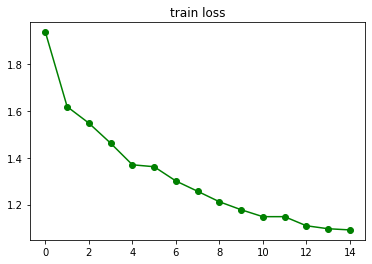

Test set average Evaluation loss : 3.0036 | accuracy : 19.17 %


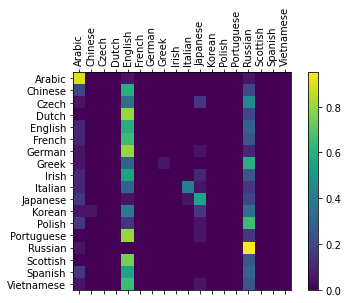

In [18]:
hw6q2train(train_dataset, rnn, loss_func1, optimizer_sgd1, num_epochs, plot_every, 'rnn')
hw6q2evaluate(test_dataset, rnn, loss_func1, all_categories, 'rnn')

In [13]:
learning_rate = 0.001
n_hidden = 128
num_epochs = 5
plot_every = 5000
gru = GRU(n_letters, n_hidden, n_categories)
loss_func2 = nn.NLLLoss()
optimizer_sgd2 = optim.SGD(gru.parameters(), lr = learning_rate, momentum = 0.0)

Epoch [1/5] | Iteration [5000/19714] | Train Loss: 2.2759
Epoch [1/5] | Iteration [10000/19714] | Train Loss: 1.8193
Epoch [1/5] | Iteration [15000/19714] | Train Loss: 1.7740
Epoch [2/5] | Iteration [5000/19714] | Train Loss: 1.6786
Epoch [2/5] | Iteration [10000/19714] | Train Loss: 1.6431
Epoch [2/5] | Iteration [15000/19714] | Train Loss: 1.5993
Epoch [3/5] | Iteration [5000/19714] | Train Loss: 1.5362
Epoch [3/5] | Iteration [10000/19714] | Train Loss: 1.4996
Epoch [3/5] | Iteration [15000/19714] | Train Loss: 1.4423
Epoch [4/5] | Iteration [5000/19714] | Train Loss: 1.4135
Epoch [4/5] | Iteration [10000/19714] | Train Loss: 1.4368
Epoch [4/5] | Iteration [15000/19714] | Train Loss: 1.3744
Epoch [5/5] | Iteration [5000/19714] | Train Loss: 1.3791
Epoch [5/5] | Iteration [10000/19714] | Train Loss: 1.3283
Epoch [5/5] | Iteration [15000/19714] | Train Loss: 1.3318


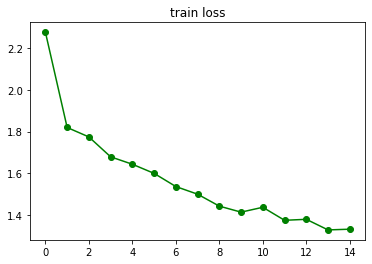

Test set average Evaluation loss : 3.5196 | accuracy : 12.22 %


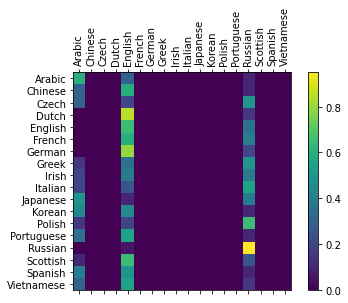

In [14]:
hw6q2train(train_dataset, gru, loss_func2, optimizer_sgd2, num_epochs, plot_every, 'gru')
hw6q2evaluate(test_dataset, gru, loss_func2, all_categories, 'gru')

In [15]:
learning_rate = 0.001
n_hidden = 128
num_epochs = 5
plot_every = 5000
lstm = LSTM(n_letters, n_hidden, n_categories)
loss_func3 = nn.NLLLoss()
optimizer_sgd3 = optim.SGD(lstm.parameters(), lr = learning_rate, momentum = 0.0)

Epoch [1/5] | Iteration [5000/19714] | Train Loss: 2.3590
Epoch [1/5] | Iteration [10000/19714] | Train Loss: 1.8904
Epoch [1/5] | Iteration [15000/19714] | Train Loss: 1.7700
Epoch [2/5] | Iteration [5000/19714] | Train Loss: 1.7923
Epoch [2/5] | Iteration [10000/19714] | Train Loss: 1.7480
Epoch [2/5] | Iteration [15000/19714] | Train Loss: 1.7001
Epoch [3/5] | Iteration [5000/19714] | Train Loss: 1.6493
Epoch [3/5] | Iteration [10000/19714] | Train Loss: 1.6541
Epoch [3/5] | Iteration [15000/19714] | Train Loss: 1.6110
Epoch [4/5] | Iteration [5000/19714] | Train Loss: 1.5502
Epoch [4/5] | Iteration [10000/19714] | Train Loss: 1.5405
Epoch [4/5] | Iteration [15000/19714] | Train Loss: 1.4992
Epoch [5/5] | Iteration [5000/19714] | Train Loss: 1.4612
Epoch [5/5] | Iteration [10000/19714] | Train Loss: 1.4819
Epoch [5/5] | Iteration [15000/19714] | Train Loss: 1.4608


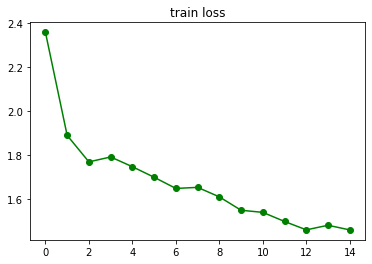

Test set average Evaluation loss : 3.5983 | accuracy : 8.89 %


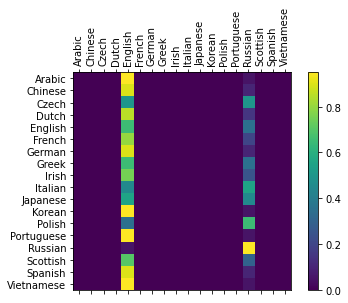

In [16]:
hw6q2train(train_dataset, lstm, loss_func3, optimizer_sgd3, num_epochs, plot_every, 'lstm')
hw6q2evaluate(test_dataset, lstm, loss_func3, all_categories, 'lstm')

#### loading dataset to variables

In [ ]:

train_dataset = 
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_sample_size = 1000
test_sample_size = 100
train_per_class_size = 100
test_per_class_size = 10
num_class = 10

#print(type(train_dataset))
#print(train_dataset[0])
#print(type(test_dataset))
#print(type(test_dataset[0]))
#print(test_dataset[0][0][0].shape)
#print(test_dataset[0])
"""
plt.imshow(train_dataset[0][0][0], cmap="gray")
image = np.expand_dims(train_dataset[0][0][0], axis=2)
print(image.shape)
print(train_dataset[0][1])
plt.show()

plt.imshow(test_dataset[0][0][0], cmap="gray")
image1 = np.expand_dims(test_dataset[0][0][0], axis=2)
print(image1.shape)
print(test_dataset[0][1])
plt.show()
"""

#print(image)
Y_traindataset = list()

for i in range(len(train_dataset)):
  Y_traindataset.append(train_dataset[i][1])

Y_testdataset = list()

for i in range(len(test_dataset)):
  Y_testdataset.append(test_dataset[i][1])

XY_train = list()
XY_test = list()

for i in range(num_class):
    indices_train = np.where(np.array(Y_traindataset) == i)[0]
    for j in range(train_per_class_size):
        XY_train.append(train_dataset[indices_train[j]])
    indices_test = np.where(np.array(Y_testdataset) == i)[0]
    for j in range(test_per_class_size):
        XY_test.append(test_dataset[indices_test[j]])

#index, (images, labels) = enumerate(XY_train)
#print(images.shape)
#print(labels.shape)
#XY_train = TensorDataset(XY_train)
#XY_test = TensorDataset(XY_test)

#print(len(XY_train))
#print(XY_train[0][0].shape)

## Homework 4
#### Forward propogation

In [ ]:
def hw2q3Replication_padding(channel, width, height, padding_width, padding_height, img):
    input = np.zeros((width + padding_width, height + padding_height, channel), float)
    for i in range(width):
        for j in range(height):
            for c in range(channel):
                input[i + int((padding_width)/2)][j + int((padding_height)/2)][c] = img[i][j][c]
    for i in range(0, int((padding_width)/2)):
        for j in range(int((padding_height)/2), height + int((padding_height)/2)):
            for c in range(channel):
                input[i][j][c] = input[padding_width - 1 - i][j][c]
                input[width + padding_width - 1 - i][j] = input[width + i][j] 
    for i in range(0, width + padding_width):
        for j in range(0, int((padding_height)/2)):
            for c in range(channel):
                input[i][j][c] = input[i][padding_height - 1 - j][c]
                input[i][height + padding_height - 1 - j] = input[i][height + j]
    return input

def hw3q1Striding(width, height, kernel_width, kernel_height, padding_width, padding_height, stride_width, stride_height, conv_output):
    output = np.zeros((int((width - kernel_width + padding_width + stride_width)/stride_width), int((height - kernel_height + padding_height + stride_height)/stride_height)), float)
    k=0
    i=0
    while(i >= 0 and i < (width - kernel_width + padding_width + 1) and k >= 0 and k < (int((width - kernel_width + padding_width + stride_width)/stride_width))):
        l = 0
        j = 0
        while(j >= 0 and j < (height - kernel_height + padding_height + 1) and l >= 0 and l < (int((height - kernel_height + padding_height + stride_height)/stride_height)) ):
            output[k][l] = conv_output[i][j]
            j = j + stride_height
            l = l + 1
        i = i + stride_width
        k = k + 1
    return output

def sigmoid(z):
    sig = (1.0/(1+np.exp(-z)))
    return sig

def tanh(z):
    return np.tanh(z)

def ReLU(z):
    return max(0, z)

def PReLU(z, alpha):
    return max(0, z) + alpha * min(0, z)

In [ ]:
def hw3q1Convolution(img, kernel, stride, padding, nl_func, alpha=0):
    width = img.shape[0]
    height = img.shape[1]
    channel = img.shape[2]
    kernel_width = kernel.shape[0]
    kernel_height = kernel.shape[1]
    padding_width = padding[0]
    padding_height = padding[1]
    stride_width = stride[0]
    stride_height = stride[1]
    input = hw2q3Replication_padding(channel, width, height, padding_width, padding_height, img)
    conv_output = np.zeros((width  + padding_width , height + padding_height), float)
    for i in range(int((kernel_width-1)/2), width + padding_width - int((kernel_width-1)/2) ):
        for j in range(int((kernel_height-1)/2), height + padding_height - int((kernel_height-1)/2)):
            for c in range(channel):
                for k in range(-int((kernel_width - 1)/2), int((kernel_width - 1)/2) + 1):
                    for l in range(-int((kernel_height - 1)/2), int((kernel_height - 1)/2) + 1):
                        #if (i - k) >= 0 and (i - k) < (width - kernel_width + padding_width + 1) and (j - l) >= 0 and (j - l) < (height - kernel_height + padding_height + 1):
                        conv_output[i][j] += input[i - k][j - l][c] * kernel[int((kernel_width - 1)/2) + k][int((kernel_height - 1)/2)+ l][c]
                        #print(conv_output[i][j], input[i - k][j - l][c], " * ", kernel[int((kernel_width - 1)/2) + k][int((kernel_height - 1)/2)+ l][c])
    #print(conv_output)
    conv_output = conv_output[int((kernel_width - 1)/2):int(width + padding_width - int((kernel_width - 1)/2)), int((kernel_height - 1)/2):int(height + padding_height - int((kernel_height - 1)/2))].astype(float)
    #print("conv_output : ", conv_output)
    output_temp = hw3q1Striding(width, height, kernel_width, kernel_height, padding_width, padding_height, stride_width, stride_height, conv_output)
    before_activation = output_temp
    #output_temp = (255*(output_temp - np.min(output_temp))/np.ptp(output_temp)).astype(float)
    for i in range(int((width - kernel_width + padding_width + stride_width)/stride_width)):
        for j in range(int((height - kernel_height + padding_height + stride_height)/stride_height)):
            if nl_func == 'sigmoid':
                output_temp[i][j] = sigmoid(output_temp[i][j])
            elif nl_func == 'tanh':
                output_temp[i][j] = tanh(output_temp[i][j])
            elif nl_func == 'ReLU':
                output_temp[i][j] = ReLU(output_temp[i][j])
            elif nl_func == 'PReLU':
                output_temp[i][j] = PReLU(output_temp[i][j], alpha)
    #print(output_temp)
    return before_activation, output_temp

In [ ]:
#Pooling function

def hw3q2Maximum(activation_pool):
    max = activation_pool[0][0]
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            if activation_pool[i][j] > max:
                max = activation_pool[i][j]
    return max

def hw3q2Average(activation_pool):
    sum = 0
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            sum += activation_pool[i][j]
    count = activation_pool.shape[0] * activation_pool.shape[1]
    return (sum/count)

def hw3q2Norm(activation_pool):
    sum = 0
    for i in range(activation_pool.shape[0]):
        for j in range(activation_pool.shape[1]):
            sum += (activation_pool[i][j]*activation_pool[i][j])
    return np.sqrt(sum)

In [ ]:
def hw3q2Pooling(activation_map, pool_func, pool_size, pool_stride):
    width = activation_map.shape[0]
    height = activation_map.shape[1]
    pool_width = pool_size[0]
    pool_height = pool_size[1]
    pool_stride_width = pool_stride[0]
    pool_stride_height = pool_stride[1]
    #print(activation_map.shape)
    Y = np.zeros((width - pool_width + 1, height - pool_height + 1), float)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            #print(activation_map[i:i+pool_width, j:j+pool_height].flatten().shape)
            if pool_func == 'maximum':
                Y[i][j] = hw3q2Maximum(activation_map[i:i+pool_width, j:j+pool_height])
            elif pool_func == 'average':
                Y[i][j] = hw3q2Average(activation_map[i:i+pool_width, j:j+pool_height])
            elif pool_func == 'norm':
                Y[i][j] = hw3q2Norm(activation_map[i:i+pool_width, j:j+pool_height])
    output = np.zeros((int((width - pool_width + pool_stride_width)/pool_stride_width), int((height - pool_height + pool_stride_height)/pool_stride_height)), float)
    i = 0
    k = 0
    while( i >= 0 and i < (width - pool_width + 1) and k >= 0 and k < int((width - pool_width + pool_stride_width)/pool_stride_width)):
        j = 0
        l = 0
        while( j >= 0 and j < (height - pool_height + 1) and l >= 0 and l < int((height - pool_height + pool_stride_height)/pool_stride_height)):
            output[k][l] = Y[i][j]
            j = j + pool_stride_height
            l = l + 1
        i = i + pool_stride_width
        k = k + 1
    return output

In [ ]:
#convolution layer 

#def hw3q3RandomKernels(num_kernels, kernel_size):
def hw3q3RandomKernels(num_kernels, kernel_size, input_size):
    kernels = list()
    for m in range(num_kernels):
        #kernels.append(np.random.randn(kernel_size[0], kernel_size[1], kernel_size[2]))
        #temp = np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))
        kernels.append(np.random.uniform(low=-(np.sqrt(1/(input_size[0]*input_size[1]))), high=(np.sqrt(1/(input_size[0]*input_size[1]))), size=(kernel_size[0], kernel_size[1], kernel_size[2])))
        #kernels.append(np.random.uniform(low=-(np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))), high=(np.sqrt(1/(kernel_size[0]*kernel_size[1]*kernel_size[2]))), size =(kernel_size[0], kernel_size[1], kernel_size[2])))
        #print(kernels[m])
    return np.array(kernels)

def hw3q3RandomKernelBias(num_kernels, bias_size):
    return np.zeros((bias_size[0], bias_size[1], num_kernels), float)

def hw3q3ConvolutionLayer(img, kernels, kernel_bias, stride, padding, nl_func, alpha=0):
    width = img.shape[0]
    height = img.shape[1]
    channel = img.shape[2]
    stride_width = stride[0]
    stride_height = stride[1]
    padding_width = padding[0]
    padding_height = padding[1]
    kernel_width = kernels.shape[1]
    kernel_height = kernels.shape[2]
    output = np.zeros((int((width - kernel_width + padding_width + stride_width)/stride_width), int((height - kernel_height + padding_height + stride_height)/stride_height), kernels.shape[0]), float)
    before_activation_list = np.zeros(output.shape, float)
    for m in range(kernels.shape[0]):
        #print("kernel : ", kernels[m])
        before_activation, output_temp = hw3q1Convolution(img, kernels[m], stride, padding, nl_func, alpha)
        #before_activation_list.append(before_activation)
        #print("output_temp : ", output_temp)
        #plt.imshow(output_temp)
        #plt.show()
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                output[i][j][m] = output_temp[i][j]
                before_activation_list[i][j][m] = before_activation[i][j]
    output = output + np.transpose(kernel_bias)
    return before_activation_list, output

In [ ]:
#Pooling Layer Function

def hw3q4PoolingLayer(activation_map, pool_func, pool_layer_size, pool_layer_stride):
    width = activation_map.shape[0]
    height = activation_map.shape[1]
    M = activation_map.shape[2]
    pool_layer_width = pool_layer_size[0]
    pool_layer_height = pool_layer_size[1]
    pool_layer_stride_width = pool_layer_stride[0]
    pool_layer_stride_height = pool_layer_stride[1]
    Y = np.zeros((int((width - pool_layer_width + pool_layer_stride_width)/pool_layer_stride_width), int((height - pool_layer_height + pool_layer_stride_height)/pool_layer_stride_height), M), float)
    for m in range(M):
        y = hw3q2Pooling(activation_map[:,:,m], pool_func,pool_layer_size, pool_layer_stride)
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                Y[i][j][m] = y[i][j]
    return Y

In [ ]:
#Flattening (unraveling) Function

def hw3q5Flattening(pooled_volume, flattening_matrix, flattening_matrix_flag):
    array1d = list()
    for i in range(pooled_volume.shape[0]):
        for j in range(pooled_volume.shape[1]):
            for m in range(pooled_volume.shape[2]):
                array1d.append(pooled_volume[i][j][m])
    array1d = np.array(array1d)
    if flattening_matrix_flag:
        output = np.matmul(flattening_matrix, array1d)
    else:
        output = array1d
    return np.expand_dims(output, axis = 1)

In [ ]:
#Multilayer Perceptron (MLP) function (Fully Connected)

def RandomMatrices(flattened_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size):
    hidden_layer_matrices = list()
    hidden_layer_bias = list()
    #hidden_layer_matrices.append(np.random.randn(hidden_layer_sizes[0], flattened_vector_size))
    hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/flattened_vector_size)), high=(np.sqrt(1/flattened_vector_size)), size=(hidden_layer_sizes[0], flattened_vector_size)))
    #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[0])), high=(np.sqrt(1/hidden_layer_sizes[0])), size=(hidden_layer_sizes[0], flattened_vector_size)))
    hidden_layer_bias.append(np.zeros((hidden_layer_sizes[0], 1), float))
    for t in range(num_hidden_layer):
        if t == (num_hidden_layer - 1):
            #hidden_layer_matrices.append(np.random.randn(output_layer_size, hidden_layer_sizes[t]))
            hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t])), high=(np.sqrt(1/hidden_layer_sizes[t])), size=(output_layer_size, hidden_layer_sizes[t])))
            #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/output_layer_size)), high=(np.sqrt(1/output_layer_size)), size=(output_layer_size, hidden_layer_sizes[t])))
            hidden_layer_bias.append(np.zeros((output_layer_size, 1), float))
        else:
            #hidden_layer_matrices.append(np.random.randn(hidden_layer_sizes[t+1], hidden_layer_sizes[t]))
            hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t])), high=(np.sqrt(1/hidden_layer_sizes[t])), size=(hidden_layer_sizes[t+1], hidden_layer_sizes[t])))
            #hidden_layer_matrices.append(np.random.uniform(low=-(np.sqrt(1/hidden_layer_sizes[t+1])), high=(np.sqrt(1/hidden_layer_sizes[t+1])), size=(hidden_layer_sizes[t+1], hidden_layer_sizes[t])))
            hidden_layer_bias.append(np.zeros((hidden_layer_sizes[t+1], 1), float))
        #print("hidden_layer_matrices :" , hidden_layer_matrices[t])
    return hidden_layer_matrices, hidden_layer_bias

def hw3q6MLP(input_vector, hidden_layer_matrices, hidden_layer_bias, nl_func, softmax_flag, alpha = 0):
    output_before_activation = list()
    output_after_activation = list()
    for i in range(len(hidden_layer_matrices)):
        if i == 0:
            #print("hidden_layer_matrices : ", hidden_layer_matrices[i].shape)
            #print("input vector : ", input_vector.shape)
            output = np.matmul(hidden_layer_matrices[i], input_vector)
        else:
            output = np.matmul(hidden_layer_matrices[i], output)
        #print("output:", output.shape)
        #print("output: ", output)
        output = output + hidden_layer_bias[i]
        #print(output.shape)
        #print(hidden_layer_bias[i].shape)
        #print("output:", output.shape)
        #print("output: ", output)
        output_before_activation.append(output)
        if i != (len(hidden_layer_matrices) - 1):
            for j in range(output.shape[0]):
                for k in range(output.shape[1]):
                    if nl_func == 'sigmoid':
                        output[j][k] = sigmoid(output[j][k])
                    elif nl_func == 'tanh':
                        output[j][k] = tanh(output[j][k])
                    elif nl_func == 'ReLU':
                        output[j][k] = ReLU(output[j][k])
                    elif nl_func == 'PReLU':
                        output[j][k] = leakyrelu(output[j][k], alpha)
            output_after_activation.append(output)
        elif i == (len(hidden_layer_matrices) - 1) and not softmax_flag:
            for j in range(output.shape[0]):
                for k in range(output.shape[1]):
                    if nl_func == 'sigmoid':
                        output[j][k] = sigmoid(output[j][k])
                    elif nl_func == 'tanh':
                        output[j][k] = tanh(output[j][k])
                    elif nl_func == 'ReLU':
                        output[j][k] = ReLU(output[j][k])
                    elif nl_func == 'PReLU':
                        output[j][k] = leakyrelu(output[j][k], alpha)
            output_after_activation.append(output)
        """
        for j in range(output.shape[0]):
            for k in range(output.shape[1]):
                if nl_func == 'sigmoid':
                    output[j][k] = sigmoid(output[j][k])
                elif nl_func == 'tanh':
                    output[j][k] = tanh(output[j][k])
                elif nl_func == 'ReLU':
                    output[j][k] = ReLU(output[j][k])
                elif nl_func == 'PReLU':
                    output[j][k] = leakyrelu(output[j][k], alpha)
        """
        #print("output: ", output)
    #print(output_before_activation[0].shape)
    return output_before_activation, output_after_activation, output

def hw3q6SoftmaxLayer(input):
    input = np.transpose(input)
    return np.transpose(np.exp(input-np.max(input,axis=1).reshape(-1,1))/np.expand_dims(np.sum(np.exp(input-np.max(input,axis=1).reshape(-1,1)),axis=1), axis=-1))
    """
    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            sum = sum + np.exp(input[i][j])
    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            input[i][j] = (np.exp(input[i][j])/sum)
    return np.transpose(input)
    """

In [ ]:
def hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array):
    kernels_array = list()
    kernel_bias = list()
    final_pooled_output_size = list()
    for i in range(num_kernels_array.shape[0]):
        if i == 0:
            #kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], image.shape[2]))
            kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], image.shape[2]), [image.shape[0], image.shape[1]])
            temp_width = int((image.shape[0] - kernels_size_array[i][0] + layer_padding[i][0] + stride_array[i][0])/stride_array[i][0])
            temp_height = int((image.shape[1] - kernels_size_array[i][1] + layer_padding[i][1] + stride_array[i][1])/stride_array[i][1])
        else:
            #kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], num_kernels_array[i-1]))
            kernels = hw3q3RandomKernels(num_kernels_array[i], np.append(kernels_size_array[i], num_kernels_array[i-1]), [layer_pooled_output_width, layer_pooled_output_height])
            temp_width = int((layer_pooled_output_width - kernels_size_array[i][0] + layer_padding[i][0] + stride_array[i][0])/stride_array[i][0])
            temp_height = int((layer_pooled_output_height - kernels_size_array[i][1] + layer_padding[i][1] + stride_array[i][1])/stride_array[i][1])
        kernel_bias_temp = np.zeros((num_kernels_array[i], 1, 1), float)
        kernels_array.append(kernels)
        kernel_bias.append(kernel_bias_temp)
        layer_pooled_output_width = int((temp_width - pool_layer_size_array[i][0] + pool_stride_array[i][0])/pool_stride_array[i][0])
        layer_pooled_output_height = int((temp_width - pool_layer_size_array[i][1] + pool_stride_array[i][1])/pool_stride_array[i][1])
    final_pooled_output_size.append(layer_pooled_output_width)
    final_pooled_output_size.append(layer_pooled_output_height)
    final_pooled_output_size.append(num_kernels_array[-1])
    return kernels_array, kernel_bias, final_pooled_output_size
        
def hw3q7FeedForwardPath(img, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag):
    output_before_kernel_act = list()
    output_after_kernel_act = list()
    pooled_output_list = list()
    pooled_output = img
    #print("img: ", img)
    for i in range(num_kernels_array.shape[0]):
        before_activation_list, output = hw3q3ConvolutionLayer(pooled_output, kernels_array[i], kernel_bias[i], stride_array[i], layer_padding[i], nl_func)
        #print("before_activation_list: ", before_activation_list)
        #print("output: ", output)
        output_before_kernel_act.append(before_activation_list)
        output_after_kernel_act.append(output)
        #print(conv_output.shape)
        pooled_output = hw3q4PoolingLayer(output, pool_func, pool_layer_size_array[i], pool_stride_array[i])
        #print("pooled_output: ", pooled_output)
        pooled_output_list.append(pooled_output)
        #print(pooled_output.shape)
    flattened_output = hw3q5Flattening(pooled_output, flattening_matrix, flattening_matrix_flag)
    output_before_activation, output_after_activation, MLP_output = hw3q6MLP(flattened_output, hidden_layer_matrices, hidden_layer_bias, nl_func, softmax_flag)
    #print("MLP ouptut : ", MLP_output)
    if softmax_flag:
        softmax_output = hw3q6SoftmaxLayer(MLP_output)
        output_after_activation.append(softmax_output)
    return output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, np.transpose(softmax_output)[0]

In [ ]:
def hw1q3aEntropy(pmf):
    pmf = pmf[pmf > 0]
    h = -np.sum(pmf * np.log2(pmf))
    if(h == -0.0):
        return np.abs(h)
    else:
        return h

def hw1q7aRelativeEntropy(pmf1, pmf2):
    h = 0
    for i in range(pmf1.shape[0]):
        if pmf1[i] == 0.0 or pmf2[i] == 0.0:
            continue
        temp = pmf1[i] * np.log2(pmf1[i]/pmf2[i])
        #print(temp)
        h += temp
    return h

def hw2q1aCrossEntropy(pmf1, pmf2):
    div = hw1q7aRelativeEntropy(pmf1, pmf2)
    ent = hw1q3aEntropy(pmf1)
    cross_ent = ent + div
    return cross_ent

#### single image Example taken for forward propogation and calculating cross entropy loss 

In [ ]:
num_kernels_array = np.array([4, 4])
kernels_size_array = np.array([[5,5], [5,5]])
layer_padding = np.array([[0, 0], [0,0]])
stride_array = np.array([[1,1], [1,1]])
pool_layer_size_array = np.array([[2,2], [2,2]])
pool_stride_array = np.array([[2,2], [2,2]])
num_hidden_layer = 1
hidden_layer_sizes = np.array([49])
output_layer_size = 10
softmax_flag = True
nl_func = 'ReLU'
pool_func = 'maximum'
flattening_matrix_flag = True

if flattening_matrix_flag:
    flattening_vector_size = 40
else:
    width = image.shape[0]
    height = image.shape[1]
    for i in range(num_kernels_array.shape[0]):
        width = int((((width - kernels_size_array[i, 0] + layer_padding[i, 0] + stride_array[i, 0])/stride_array[i, 0]) - pool_layer_size_array[i, 0] + pool_stride_array[i, 0])/pool_stride_array[i, 0])
        height = int((((height - kernels_size_array[i, 1] + layer_padding[i, 1] + stride_array[i, 1])/stride_array[i, 1]) - pool_layer_size_array[i, 1] + pool_stride_array[i, 1])/pool_stride_array[i, 1])
    flattening_vector_size = width * height * num_kernels_array[num_kernels_array.shape[0] - 1]

kernels_array, kernel_bias, final_pooled_output_size = hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array)

hidden_layer_matrices, hidden_layer_bias = RandomMatrices(flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size)

#print("kernels_array :", kernels_array)
#print("kernel_bias :", kernel_bias)
#print("hidden_layer_matrices :", hidden_layer_matrices)
#print("hidden_layer_bias :", hidden_layer_bias)

flattening_matrix = np.random.randn(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2])
#flattening_matrix = np.random.uniform(low=-(np.sqrt(1/(final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))), high=(np.sqrt(1/(final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))), size=(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]))

#print("before image : ", image)
#image1 = (image - 0.5)/0.5
#print("image : ", image1)

output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(image, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)

"""
print("value of C2 is equal to the number of kernels in the previous convolution layer - 16")
print("original input image size : ", image.shape)
print("original image")
plt.imshow(image)
plt.show()
"""

print("Ouput vector size : ", output_vector.shape)
print(output_vector)
plt.plot(output_vector)
plt.show()

y_hat = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
print(hw2q1aCrossEntropy(y_hat, output_vector))


#### Backward propogation (q3)

In [ ]:
def hw4q3ZeroPadding(channel, width, height, padding_width, padding_height, img):
    input = np.zeros((width + padding_width, height + padding_height, channel), float)
    for i in range(width):
        for j in range(height):
            for c in range(channel):
                input[i + int((padding_width)/2)][j + int((padding_height)/2)][c] = img[i][j][c]
    return input

def hw4q3LinearDerivatives(dZ, A, W, b):
    #print(dZ.shape)
    #print(A.shape)
    #print(W.shape)
    #print(b.shape)
    dW = np.zeros((W.shape[0], W.shape[1]), float)
    for i in range(dW.shape[0]):
        for j in range(dW.shape[1]):
            #print("dZ : ", dZ[i], A[j])
            dW[i][j] = dZ[i]*A[j]
            #print("W :", W[i][j])
    #print(dW.shape)
    db = np.sum(dZ, axis = 1, keepdims = True)
    #print("db: ", db.shape)
    dA_prev = np.zeros(A.shape, float)
    for i in range(dA_prev.shape[0]):
        for j in range(dA_prev.shape[1]):
            dA_prev[i][j] = np.sum(np.multiply(dZ[:, 0], W[:, i]))
    return dA_prev, dW, db

def softmaxDerivative(dA, Z):
    #print("Z : ", Z)
    #print(Z.shape)
    #print("dA : ", dA.shape)
    exp_Z = np.exp(Z)
    dZ = np.zeros(Z.shape, float)
    #print("exp_z: ", exp_Z)
    A = exp_Z / np.sum(exp_Z)
    for i in range(dZ.shape[0]):
        for j in range(dZ.shape[1]):
            dZ[i][j] = dA[i][j] * A[i][j] * ( 1 - A[i][j])
    """
    dA_A = np.sum(dA * A, axis = 0)
    temp = dA - dA_A
    dZ = A * temp
    """
    return dZ

def sigmoidDerivative(dA, Z):
    temp = 1 / (1 + np.exp(-Z))
    dZ = dA * temp * (1 - temp)
    return dZ

def ReLUDerivative(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def hw4q3ActivationDerivatives(dA, Z, A, W, b, nl_func):
    #print("dA" , dA.shape)
    #print("Z" , Z.shape)
    #print("A" , A.shape)
    #print("W" , W.shape)
    #print("b" , b.shape)
    if nl_func == "softmax":
        dZ = softmaxDerivative(dA, Z)
    elif nl_func == "sigmoid":
        dZ = sigmoidDerivative(dA, Z)
    elif nl_func == "ReLU":
        dZ = ReLUDerivative(dA, Z)
        
    #print("dZ : ", dZ)
    dA_prev, dW, db = hw4q3LinearDerivatives(dZ, A, W, b)
    #print("dW :", dW)
    #print("db :", db)
    
    return dA_prev, dZ, dW, db

def hw4q3KernelActivationDerivative(dP, Z, A, W, b, kernel_size, stride_size, nl_func, layer_padding):
    dZ = np.zeros(dP.shape, float)
    for k in range(dP.shape[2]):
        if nl_func == "softmax":
            dZ_temp = softmaxDerivative(dP[:, :, k], Z[:, :, k])
        elif nl_func == "sigmoid":
            dZ_temp = sigmoidDerivative(dP[:, :, k], Z[:, :, k])
        elif nl_func == "ReLU":
            dZ_temp = ReLUDerivative(dP[:, :, k], Z[:, :, k])
        for i in range(dP.shape[0]):
            for j in range(dP.shape[1]):
                dZ[i][j][k] = dZ_temp[i][j]
    dA_prev = np.zeros((A.shape[0] + layer_padding[0], A.shape[1] + layer_padding[1], A.shape[2]), float)
    #print(dA_prev.shape)
    dW = np.zeros(W.shape, float)
    #print(dW.shape)
    db = np.zeros(b.shape, float)
    #print(db.shape)

    A_repl = hw2q3Replication_padding(A.shape[2], A.shape[0], A.shape[1], layer_padding[0], layer_padding[1], A)
    for k in range(W.shape[0]):
        for c in range(W.shape[3]):
            for i in range(W.shape[0]):
                for j in range(W.shape[1]):
                    #print(A_repl[(A_repl.shape[0] - dZ.shape[0] - i):(A_repl.shape[0] - i):stride_size[0], (A_repl.shape[1] - dZ.shape[1] - j):(A_repl.shape[1] - j):stride_size[1], c])
                    #print(dZ[:, :, k])
                    dW[k, i, j, c] += np.sum(np.multiply(A_repl[(A_repl.shape[0] - dZ.shape[0] - i):(A_repl.shape[0] - i):stride_size[0], (A_repl.shape[1] - dZ.shape[1] - j):(A_repl.shape[1] - j):stride_size[1], c], dZ[:, :, k]))

    dZ_padd = hw4q3ZeroPadding(dZ.shape[2], dZ.shape[0], dZ.shape[1], 2 * (W.shape[1] - 1), 2 * (W.shape[2] - 1), dZ)
    for k in range(dA_prev.shape[2]):
        for i in range(dA_prev.shape[0]):
            for j in range(dA_prev.shape[1]):
                for m in range(dZ.shape[2]):
                    dA_prev[i, j, k] += np.sum(np.multiply(W[m, :, :, k], dZ_padd[i:i+W.shape[1], j:j+W.shape[2], m]))
    dA_prev = dA_prev[int(layer_padding[0]/2):dA_prev.shape[0] - int(layer_padding[0]/2), int(layer_padding[1]/2):dA_prev.shape[1] - int(layer_padding[1]/2), :]
    
    for m in range(dZ.shape[2]):
        db[m, 0, 0] = np.sum(dZ[:, :, m])

    return dA_prev, dZ, dW, db

def hw4q3PoolDerivative(dP, output, pool_size, pool_stride_size):
    dX = np.zeros((output.shape[0], output.shape[1], output.shape[2]), float)
    for k in range(output.shape[2]):
        for i in range(0, output.shape[0] - pool_size[0] + 1, pool_stride_size[0]):
            for j in range(0, output.shape[0] - pool_size[1] + 1, pool_stride_size[1]):
                index_1d = np.argmax(output[i:i+pool_size[0], j:j+pool_size[1], k])
                (idx, idy) = np.unravel_index(index_1d, (pool_size[0], pool_size[1]))
                dX[i+idx, j+idy, k] += dP[int(i/pool_stride_size[0]), int(j/pool_stride_size[1]), k]
    return dX

def hw4q3FlatteningDerivative(dO, pooled_output, flattening_matrix, flattening_matrix_flag):
    array1d = list()
    for i in range(pooled_output.shape[0]):
        for j in range(pooled_output.shape[1]):
            for m in range(pooled_output.shape[2]):
                array1d.append(pooled_output[i][j][m])
    array1d = np.expand_dims(np.array(array1d), axis = 1)
    if flattening_matrix_flag:
        dF = np.matmul(dO, array1d.T)
    #print(dW.shape)
    #db = np.sum(dZ, axis = 1, keepdims = True)
    #print("db: ", db.shape)
        dP_temp = np.matmul(flattening_matrix.T, dO)
    else: 
        dP_temp = dO
    dP = np.zeros((pooled_output.shape[0], pooled_output.shape[1], pooled_output.shape[2]), float)
    n = 0
    for i in range(pooled_output.shape[0]):
        for j in range(pooled_output.shape[1]):
            for m in range(pooled_output.shape[2]):
                dP[i][j][m] = dP_temp[n][0]
                n += 1
    if flattening_matrix_flag:
        return dP, dF
    else:
        return dP

def hw4q3LayerDerivatives(input_img, output_vector, y_hat, output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias,  output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding):
    L = len(hidden_layer_matrices)
    #print(output_vector.shape)
    #print(y_hat.shape)
    dAF = np.expand_dims(- (np.divide(y_hat, output_vector)), axis = 1)
    #print(dAF.shape)
    dA_array = [None] * L
    dZ_array = [None] * L
    dW_array = [None] * L
    db_array = [None] * L
    for i in reversed(range(L)):
        if i == L - 1:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dAF, output_before_activation[i], output_after_activation[i - 1], hidden_layer_matrices[i], hidden_layer_bias[i], "softmax")
        elif i == 0:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dA_array[i + 1], output_before_activation[i], flattened_output, hidden_layer_matrices[i], hidden_layer_bias[i], nl_func)
        else:
            dA_temp, dZ_temp, dW_temp, db_temp = hw4q3ActivationDerivatives(dA_array[i + 1], output_before_activation[i], output_after_activation[i - 1], hidden_layer_matrices[i], hidden_layer_bias[i], nl_func)
        #print("dW_temp : ", dW_temp)
        dA_array[i] = dA_temp
        dZ_array[i] = dZ_temp
        dW_array[i] = dW_temp
        db_array[i] = db_temp
        """
        if i == 0:
            print("dA_temp:", dA_temp.shape)
            print("dZ_temp:", dZ_temp.shape)
            print("dW_temp:", dW_temp.shape)
            print("db_temp:", dW_temp.shape)
        
            print("dA_array: ", dA_array)
            print("dZ_array: ", dZ_array)
            print("dW_array: ", dW_array)
            print("db_array: ", db_array)
        print("Layer {} completed".format(i))
        """
    if flattening_matrix_flag:
        dP, dF = hw4q3FlatteningDerivative(dA_array[0], pooled_output_list[len(pooled_output_list) - 1], flattening_matrix, flattening_matrix_flag)
    else:
        dP = hw4q3FlatteningDerivative(dA_array[0], pooled_output_list[len(pooled_output_list) - 1], flattening_matrix, flattening_matrix_flag)
    ker_L = len(pooled_output_list)
    dP_array = np.array([None] * ker_L)
    dA_kernellayer_array = [None] * ker_L
    dZ_kernellayer_array = [None] * ker_L
    dW_kernellayer_array = [None] * ker_L
    db_kernellayer_array = [None] * ker_L
    for j in reversed(range(ker_L)):
        if j == ker_L - 1:
            dP_temp = hw4q3PoolDerivative(dP, output_after_kernel_act[j], pool_layer_size_array[j], pool_stride_array[j])
        else:
            dP_temp = hw4q3PoolDerivative(dA_kernellayer_array[j + 1], output_after_kernel_act[j], pool_layer_size_array[j], pool_stride_array[j])
        if j == 0:
            dA_kernellayer_prev_temp, dZ_kernellayer_temp, dW_kernellayer_temp, db_kernellayer_temp = hw4q3KernelActivationDerivative(dP_temp, output_before_kernel_act[j], input_img, kernels_array[j], kernel_bias[j], kernels_size_array[j], stride_array[j], nl_func, layer_padding[j])
        else:
            dA_kernellayer_prev_temp, dZ_kernellayer_temp, dW_kernellayer_temp, db_kernellayer_temp = hw4q3KernelActivationDerivative(dP_temp, output_before_kernel_act[j], pooled_output_list[j - 1], kernels_array[j], kernel_bias[j], kernels_size_array[j], stride_array[j], nl_func, layer_padding[j])
        """
        if j == 0:
            print("dA_kernellayer_prev_temp : ", dA_kernellayer_prev_temp.shape)
            print("dZ_kernellayer_temp: ", dZ_kernellayer_temp.shape)
            print("dW_kernellayer_temp: ", dW_kernellayer_temp.shape)
            print("db_kernellayer_temp: ", db_kernellayer_temp.shape)
        """
        dA_kernellayer_array[j] = dA_kernellayer_prev_temp
        dZ_kernellayer_array[j] = dZ_kernellayer_temp
        dW_kernellayer_array[j] = dW_kernellayer_temp
        db_kernellayer_array[j] = db_kernellayer_temp
    
    if flattening_matrix_flag:
        return dA_array, dZ_array, dW_array, db_array, dF, dA_kernellayer_array, dZ_kernellayer_array, dW_kernellayer_array, db_kernellayer_array
    else:
        return dA_array, dZ_array, dW_array, db_array, dA_kernellayer_array, dZ_kernellayer_array, dW_kernellayer_array, db_kernellayer_array

def hw4q3SGD(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, flattening_matrix_flag):
    for i in range(len(hidden_layer_matrices)):
        #print("hidden_layer : ", hidden_layer_matrices[i])
        #print("dW_Array : ", dW_array[i])
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], dW_array[i] * learning_rate)
        #print("hidden_layer _ update :", hidden_layer_matrices[i])
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], learning_rate * db_array[i])
    if flattening_matrix_flag:
        flattening_matrix = np.subtract(flattening_matrix, learning_rate * dF)
    for i in range(len(kernels_array)):
        kernels_array[i] = np.subtract(kernels_array[i], learning_rate * dW_kernellayer_array[i])
        kernel_bias[i] = np.subtract(kernel_bias[i], learning_rate * db_kernellayer_array[i])
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias

def hw4q3Momentum(hidden_layer_matrices, hidden_layer_bias, dW_array, db_array, flattening_matrix, dF, kernels_array, kernel_bias, dW_kernellayer_array, db_kernellayer_array, change_momentum_W, change_momentum_b, change_momentum_F, change_momentum_W_kernel, change_momentum_b_kernel, flattening_matrix_flag, learning_rate, alpha):
    for i in range(len(hidden_layer_matrices)):
        change_momentum_W[i] = np.add(learning_rate * dW_array[i], alpha * change_momentum_W[i])
        change_momentum_b[i] = np.add(learning_rate * db_array[i], alpha * change_momentum_b[i])
        #print("Changed momentum : ", change_momentum_W[i].shape)
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], change_momentum_W[i])
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], change_momentum_b[i])
    if flattening_matrix_flag:
        flattening_matrix = np.subtract(flattening_matrix, np.add(learning_rate * dF, alpha * change_momentum_F))
        change_momentum_F = np.add(learning_rate * dF, alpha * change_momentum_F)
    for i in range(len(kernels_array)):
        kernels_array[i] = np.subtract(kernels_array[i], np.add(learning_rate * dW_kernellayer_array[i], alpha * change_momentum_W_kernel[i]))
        kernel_bias[i] = np.subtract(kernel_bias[i], np.add(learning_rate * db_kernellayer_array[i], alpha * change_momentum_b_kernel[i]))
        change_momentum_W_kernel[i] = np.add(learning_rate * dW_kernellayer_array[i], alpha * change_momentum_W_kernel[i])
        change_momentum_b_kernel[i] = np.add(learning_rate * db_kernellayer_array[i], alpha * change_momentum_b_kernel[i])
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, change_momentum_W, change_momentum_b, change_momentum_W_kernel, change_momentum_b_kernel, change_momentum_F

def hw4q3RMSProp(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_W_kernel, sq_b_kernel, sq_F, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, rho):
    #print("hidden_layer_matrices : ", hidden_layer_matrices)
    #print("hidden_layer_bias : ", hidden_layer_bias)
    #print("flattening_matrix : ", flattening_matrix)
    #print("kernels_array : ", kernels_array)
    #print("kernel_bias : " , kernel_bias)
    for i in range(len(hidden_layer_matrices)):
        #print("sq_W in : ", sq_W[i].shape)
        #print("sq_b in : ", sq_b[i].shape)
        #print("dW_array in : ", dW_array[i].shape)
        #print("db_array in : ", db_array[i].shape)
        sq_W[i] = np.add(rho * sq_W[i], (1 - rho) * dW_array[i])
        sq_b[i] = np.add(rho * sq_b[i], (1 - rho) * db_array[i])
        #print("sq_W out : ", sq_W[i].shape)
        #print("sq_b out : ", sq_b[i].shape)
        #print("dW_array out : ", dW_array[i].shape)
        #print("db_array out : ", db_array[i].shape)
        #print("np.sqrt(db_array[i]) out : ", np.sqrt(db_array[i]).shape)
        #print("np.sqrt(sq_b[i] out : ", np.sqrt(sq_b[i]).shape)
        hidden_layer_matrices[i] = np.subtract(hidden_layer_matrices[i], np.divide(learning_rate * np.sqrt(dW_array[i]), np.sqrt(sq_W[i]) + 1e-08))
        hidden_layer_bias[i] = np.subtract(hidden_layer_bias[i], np.divide(learning_rate * np.sqrt(db_array[i]), np.sqrt(sq_b[i]) + 1e-08))
    if flattening_matrix_flag:
        sq_F = np.add(rho * sq_F, (1 - rho) * dF)
        flattening_matrix = np.subtract(flattening_matrix, np.divide(learning_rate * np.sqrt(dF), np.sqrt(sq_F)))
    for i in range(len(kernels_array)):
        sq_W_kernel[i] = np.add(rho * sq_W_kernel[i], (1 - rho) * dW_kernellayer_array[i])
        sq_b_kernel[i] = np.add(rho * sq_b_kernel[i], (1 - rho) * db_kernellayer_array[i])
        kernels_array[i] = np.subtract(kernels_array[i], np.divide(learning_rate * np.sqrt(dW_kernellayer_array[i]), np.sqrt(sq_W_kernel[i]) + 1e-08))
        kernel_bias[i] = np.subtract(kernel_bias[i], np.divide(learning_rate * np.sqrt(db_kernellayer_array[i]), np.sqrt(sq_b_kernel[i]) + 1e-08))
    #print("hidden_layer_matrices : ", hidden_layer_matrices)
    #print("hidden_layer_bias : ", hidden_layer_bias)
    #print("flattening_matrix : ", flattening_matrix)
    #print("kernels_array : ", kernels_array)
    #print("kernel_bias : " , kernel_bias)
    return hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_F, sq_W_kernel, sq_b_kernel

def evaluate(XY_test, 
            kernels_array, 
            kernel_bias,
            hidden_layer_matrices,
            hidden_layer_bias,
            flattening_matrix,
            num_kernels_array, 
            kernels_size_array, 
            layer_padding, 
            stride_array,
            pool_layer_size_array,
            pool_stride_array,
            flattening_vector_size,
            num_hidden_layer,
            hidden_layer_sizes,
            output_layer_size,
            softmax_flag,
            nl_func,
            pool_func,
            flattening_matrix_flag,
            y_mapping):
    loss = 0
    accuracy = 0.0
    flattened_outputs = list()
    original_Y = list()
    for index, sample in enumerate(XY_test):
        X = sample[0][0]
        X = (X - 0.5)/0.5
        X = np.expand_dims(X, axis = 2)
        Y = sample[1]
        #print(X.shape)
        output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(X, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)
        flattened_outputs.append(flattened_output)
        original_Y.append(Y)
        if np.argmax(output_vector) == Y:
            accuracy += 1.0
        loss += hw2q1aCrossEntropy(y_mapping[Y], output_vector)
        #print("output : ", output_vector)
        #print("original output : ", Y)
        
        if (index + 1)%len(XY_test) == 0:
            plt.subplot(3, 3, 1)
            plt.title("original")
            plt.imshow(X, cmap="gray")
            for j in range(len(output_after_activation)):
                plt.subplot(3, 3, j + 2)
                plt.title("layer {} activation".format(j + 1))
                #print(output_after_activation[j].shape)
                plt.imshow(output_after_kernel_act[j][:, :, 0], cmap="gray")
            plt.show()
    return loss/len(XY_test), accuracy/len(XY_test), np.array(flattened_outputs), np.array(original_Y)

#y_mapping = np.identity(output_layer_size)
#evaluate(XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, y_mapping)
        

#### training function ( contains every epoch training with train data and evaluation of test data for each epoch)
#### q4, q5

In [ ]:

def train(XY_train,
          XY_test,
           kernels_array, 
          kernel_bias, 
          hidden_layer_matrices, 
          hidden_layer_bias,
            flattening_matrix,
            num_kernels_array, 
          kernels_size_array, 
          layer_padding, 
          stride_array,
          pool_layer_size_array,
          pool_stride_array,
          flattening_vector_size,
          num_hidden_layer,
          hidden_layer_sizes,
          output_layer_size,
          softmax_flag,
          nl_func,
          pool_func,
          update_func,
          flattening_matrix_flag,
          num_epochs = 30, 
          batch_size = 1,
          learning_rate = 0.01, 
          alpha = 0.9, 
          rho = 0.9
         ):
    
    y_mapping = np.identity(output_layer_size)
    
    #print(y_mapping)
    """
    print("hidden_layer_matrices: ", hidden_layer_matrices)
    print("hidden_layer_bias: ", hidden_layer_bias)
    print("Flattening_matrix: ", flattening_matrix)
    print("kernels_array: ", kernels_array)
    print("kernel_bias: ", kernel_bias)
    """
    if update_func == "momentum":
        change_momentum_W = list()
        change_momentum_b = list()
        for k in range(num_hidden_layer + 1):
            change_momentum_W.append(np.zeros(hidden_layer_matrices[k].shape, float))
            change_momentum_b.append(np.zeros(hidden_layer_bias[k].shape, float))
        change_momentum_W_kernel = list()
        change_momentum_b_kernel = list()
        for k in range(num_kernels_array.shape[0]):
            change_momentum_W_kernel.append(np.zeros(kernels_array[k].shape, float))
            change_momentum_b_kernel.append(np.zeros(kernel_bias[k].shape, float))
        change_momentum_F = np.zeros(flattening_matrix.shape, float)
    elif update_func == "RMSProp":
        sq_W = list()
        sq_b = list()
        for k in range(num_hidden_layer + 1):
            sq_W.append(np.zeros(hidden_layer_matrices[k].shape, float))
            sq_b.append(np.zeros(hidden_layer_bias[k].shape, float))
        sq_W_kernel = list()
        sq_b_kernel = list()
        for k in range(num_kernels_array.shape[0]):
            sq_W_kernel.append(np.zeros(kernels_array[k].shape, float))
            sq_b_kernel.append(np.zeros(kernel_bias[k].shape, float))
        sq_F = np.zeros(flattening_matrix.shape, float)
    loss_train = [0.0] * num_epochs
    loss_test = [0.0] * num_epochs
    avg_accuracy = [0.0] * num_epochs
    flattened_outputs_list = list()
    original_Y_list = list()
    
    for i in range(num_epochs):
        
        np.random.shuffle(XY_train)
        
        dW_array = [None] * (num_hidden_layer + 1)
        db_array = [None] * (num_hidden_layer + 1)
        for j in range(num_hidden_layer + 1):
            dW_array[j] = np.zeros(hidden_layer_matrices[j].shape, float)
            db_array[j] = np.zeros(hidden_layer_bias[j].shape, float)
        dF = np.zeros(flattening_matrix.shape, float)
        dW_kernellayer_array = [None] * num_kernels_array.shape[0]
        db_kernellayer_array = [None] * num_kernels_array.shape[0]
        for j in range(num_kernels_array.shape[0]):
            dW_kernellayer_array[j] = np.zeros(kernels_array[j].shape, float)
            db_kernellayer_array[j] = np.zeros(kernel_bias[j].shape, float)

        for index, sample in enumerate(XY_train):
            
            X = sample[0][0]
            X = (X - 0.5)/0.5
            X = np.expand_dims(X, axis = 2)
            Y = sample[1]
            
            output_before_activation, output_after_activation, flattened_output, output_before_kernel_act, output_after_kernel_act, pooled_output_list, output_vector = hw3q7FeedForwardPath(X, num_kernels_array, kernels_array, kernel_bias, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_matrix, hidden_layer_matrices, hidden_layer_bias, pool_func, nl_func, softmax_flag, flattening_matrix_flag)
            #print("y_hat: ", y_mapping[Y])
            #print("output_vector: ", output_vector)
            
            if flattening_matrix_flag:
                dA_array_temp, dZ_array_temp, dW_array_temp, db_array_temp, dF_temp, dA_kernellayer_array_temp, dZ_kernellayer_array_temp, dW_kernellayer_array_temp, db_kernellayer_array_temp = hw4q3LayerDerivatives(X, output_vector, y_mapping[Y], output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias, output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding)
            else:
                dA_array_temp, dZ_array_temp, dW_array_temp, db_array_temp, dA_kernellayer_array_temp, dZ_kernellayer_array_temp, dW_kernellayer_array_temp, db_kernellayer_array_temp = hw4q3LayerDerivatives(X, output_vector, y_mapping[Y], output_before_activation, output_after_activation, hidden_layer_matrices, hidden_layer_bias, output_before_kernel_act, output_after_kernel_act, pooled_output_list, flattened_output, kernels_array, kernel_bias, flattening_matrix, pool_layer_size_array, pool_stride_array, kernels_size_array, stride_array, nl_func, pool_func, flattening_matrix_flag, layer_padding)
            
            loss_train[i] += hw2q1aCrossEntropy(y_mapping[Y], output_vector)
            if update_func == "RMSProp":
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.add(dW_array[j], np.multiply(dW_array_temp[j], dW_array_temp[j]))
                    db_array[j] = np.add(db_array[j], np.multiply(db_array_temp[j], db_array_temp[j]))
                #print("dW_array_temp :",  dW_array_temp)
                #print("dW_array : ", dW_array)
                if flattening_matrix_flag:
                    dF = np.add(dF, np.multiply(dF_temp, dF_temp))
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.add(dW_kernellayer_array[j], np.multiply(dW_kernellayer_array_temp[j], dW_kernellayer_array_temp[j]))
                    db_kernellayer_array[j] = np.add(db_kernellayer_array[j], np.multiply(db_kernellayer_array_temp[j], db_kernellayer_array_temp[j]))
            else:
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.add(dW_array[j], dW_array_temp[j])
                    db_array[j] = np.add(db_array[j], db_array_temp[j])
                #print("dW_array_temp :",  dW_array_temp)
                #print("dW_array : ", dW_array)
                if flattening_matrix_flag:
                    dF = np.add(dF, dF_temp)
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.add(dW_kernellayer_array[j], dW_kernellayer_array_temp[j])
                    db_kernellayer_array[j] = np.add(db_kernellayer_array[j], db_kernellayer_array_temp[j])

            if (index + 1)%batch_size == 0:
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = dW_array[j]/batch_size
                    #print("dW_array[{}] : {}".format(j, dW_array[j].shape))
                    db_array[j] = db_array[j]/batch_size
                    #print("db_array[{}] : {}".format(j, db_array[j].shape))
                if flattening_matrix_flag:
                    dF = dF/batch_size
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = dW_kernellayer_array[j]/batch_size
                    db_kernellayer_array[j] = db_kernellayer_array[j]/batch_size
                #print("hidden_layer_bias in: ", hidden_layer_bias[0].shape)
                #print("hidden_layer_bias in : ", hidden_layer_bias[1].shape)
                #print("dW_array : ", dW_array)
                if update_func == "SGD":
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias = hw4q3SGD(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, flattening_matrix_flag)
                elif update_func == "momentum":
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, change_momentum_W, change_momentum_b, change_momentum_W_kernel, change_momentum_b_kernel, change_momentum_F = hw4q3Momentum(hidden_layer_matrices, hidden_layer_bias, dW_array, db_array, flattening_matrix, dF, kernels_array, kernel_bias, dW_kernellayer_array, db_kernellayer_array, change_momentum_W, change_momentum_b, change_momentum_F, change_momentum_W_kernel, change_momentum_b_kernel, flattening_matrix_flag, learning_rate, alpha)
                elif update_func == "RMSProp":
                    #print("entering here")
                    hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_F, sq_W_kernel, sq_b_kernel = hw4q3RMSProp(hidden_layer_matrices, hidden_layer_bias, flattening_matrix, kernels_array, kernel_bias, sq_W, sq_b, sq_W_kernel, sq_b_kernel, sq_F, dW_array, db_array, dF, dW_kernellayer_array, db_kernellayer_array, learning_rate, rho)
                    
                #print("loss for last image for epoch {} and batch number {}: {}".format(i, (index + 1)/batch_size, loss/batch_size))
                #print("loss for last image for epoch {} and batch number {}".format(i, (index + 1)/batch_size))
                """
                print("hidden_layer_matrices: ", hidden_layer_matrices)
                print("dW_array: ", dW_array)
                print("hidden_layer_bias: ", hidden_layer_bias)
                print("db_array: ", db_array)
                print("Flattening_matrix: ", flattening_matrix)
                print("dF: ", dF)
                print("kernels_array: ", kernels_array)
                print("dW_kernellayer_array: ", dW_kernellayer_array)
                print("kernel_bias: ", kernel_bias)
                print("db_kernellayer_array: ", db_kernellayer_array)
                """
                #print("hidden_layer_bias out : ", hidden_layer_bias[0].shape)
                #print("hidden_layer_bias out: ", hidden_layer_bias[1].shape)
                
                dW_array = [None] * (num_hidden_layer + 1)
                db_array = [None] * (num_hidden_layer + 1)
                for j in range(num_hidden_layer + 1):
                    dW_array[j] = np.zeros(hidden_layer_matrices[j].shape, float)
                    db_array[j] = np.zeros(hidden_layer_bias[j].shape, float)
                dF = np.zeros(flattening_matrix.shape, float)
                dW_kernellayer_array = [None] * num_kernels_array.shape[0]
                db_kernellayer_array = [None] * num_kernels_array.shape[0]
                for j in range(num_kernels_array.shape[0]):
                    dW_kernellayer_array[j] = np.zeros(kernels_array[j].shape, float)
                    db_kernellayer_array[j] = np.zeros(kernel_bias[j].shape, float)
            #print(dW_array)
        loss_test[i], avg_accuracy[i], flattened_outputs, original_Y = evaluate(XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, y_mapping)
        if i == 0:
            flattened_outputs_list.append(flattened_outputs)
            original_Y_list.append(original_Y)
        elif i == (num_epochs - 1):
            flattened_outputs_list.append(flattened_outputs)
            original_Y_list.append(original_Y)
        print("Train loss for epoch {} : {}".format(i, loss_train[i]/len(XY_train)))
        print("Test loss for epoch {} : {}".format(i, loss_test[i]))
        print("Accuracy for epoch {} : {}%".format(i, avg_accuracy[i]*100))
    
    plt.plot(list(range(num_epochs)), loss_train, '-go')
    plt.title("train loss")
    plt.show()
    plt.plot(list(range(num_epochs)), loss_test, '-bo')
    plt.title("test loss")
    plt.show()
    parameters = dict()
    parameters["kernels_array"] = kernels_array
    parameters["kernel_bias"] = kernel_bias
    parameters["hidden_layer_matrices"] = hidden_layer_matrices
    parameters["hidden_layer_bias"] = hidden_layer_bias
    parameters["flattening_matrix"] = flattening_matrix
    return avg_accuracy, parameters, flattened_outputs_list, original_Y_list



In [ ]:
num_kernels_array = np.array([4, 4])
kernels_size_array = np.array([[5, 5], [5, 5]])
layer_padding = np.array([[4, 4], [4, 4]])
stride_array = np.array([[1, 1], [1, 1]])
pool_layer_size_array = np.array([[2, 2], [2, 2]])
pool_stride_array = np.array([[2, 2], [2, 2]])
num_hidden_layer = 1
hidden_layer_sizes = np.array([49])
output_layer_size = 10
softmax_flag = True
nl_func = 'ReLU'
pool_func = 'maximum'
flattening_matrix_flag = False

num_epochs1 = 15
batch_size1 = 40.0
learning_rate = 0.001
alpha = 0.9
rho = 0.9

if flattening_matrix_flag:
    flattening_vector_size = 40
else:
    width = XY_train[0][0][0].shape[0]
    height = XY_train[0][0][0].shape[1]
    for i in range(num_kernels_array.shape[0]):
        width = int((((width - kernels_size_array[i, 0] + layer_padding[i, 0] + stride_array[i, 0])/stride_array[i, 0]) - pool_layer_size_array[i, 0] + pool_stride_array[i, 0])/pool_stride_array[i, 0])
        height = int((((height - kernels_size_array[i, 1] + layer_padding[i, 1] + stride_array[i, 1])/stride_array[i, 1]) - pool_layer_size_array[i, 1] + pool_stride_array[i, 1])/pool_stride_array[i, 1])
    flattening_vector_size = width * height * num_kernels_array[num_kernels_array.shape[0] - 1]


kernels_array, kernel_bias, final_pooled_output_size = hw3q7MultiLayerKernels(image, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array)

hidden_layer_matrices, hidden_layer_bias = RandomMatrices(flattening_vector_size, num_hidden_layer, hidden_layer_sizes, output_layer_size)
    
flattening_matrix = np.random.randn(flattening_vector_size, final_pooled_output_size[0]*final_pooled_output_size[1]*final_pooled_output_size[2]) * 0.001

In [ ]:
#batch_size = 40, SGD method is used
avg_accuracy1, parameters1, flattened_outputs_list1, original_Y_list1 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "SGD", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate, alpha, rho)

In [ ]:
def hw4q6TSNE(flattened_outputs_list, original_Y_list, num_epochs):
    #print(np.squeeze(flattened_outputs_list[i], axis = -1).dtype)
    flattened_outputs_list = np.array(flattened_outputs_list, dtype="float32")
    for i in range(len(flattened_outputs_list)):
        tsne =  TSNE(n_components=2, init='random')
        Y_output = tsne.fit_transform(np.squeeze(flattened_outputs_list[i], axis = -1))
        colors = ['black', 'blue', 'green', 'red', 'yellow', 'purple', 'brown', 'magenta', 'cyan', 'orange']
        for j in range(Y_output.shape[0]):
            plt.scatter(Y_output[j, 0], Y_output[j, 1], c = colors[original_Y_list[i][j]])
            plt.annotate(original_Y_list[i][j], (Y_output[j, 0], Y_output[j, 1]))
        #plt.scatter(x_axis, y_axis)
        plt.title("tSNE plot for epoch {}".format(i*num_epochs))
        plt.legend()
        plt.show()

In [ ]:
#tsne for SGD with batch size as 40
hw4q6TSNE(flattened_outputs_list1, original_Y_list1, num_epochs1)

In [ ]:
batch_size2 = 100.0
#batch_size = 100, SGD method is used
avg_accuracy2, parameters2, flattened_outputs_list2, original_Y_list2 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "SGD", flattening_matrix_flag, num_epochs1, batch_size2, learning_rate, alpha, rho)

#### below are the outputs with momentum using learning rate of 0.0001 (Below is the reason for using such low learning rate)
#### while using learning_rate = 0.001, the weights for kernel and MLP were vanishing (sometimes exploding) causing the final 10 dim vector output to contain Nan, which resulted in errors also to be Nan and activation maps to be blank while screen
#### There was other option as well for having a correct numerical error and accuracy by using normal distributed random weights and bias generation but I was not sure enough to use it
#### There is another possible way by reducing the number of epochs which we are learning for ignoring outputs that are vanishing to Nan
#### Same handling is being done in outputs with RMSProp also

In [ ]:
#batch_size = 40, momentum method is used

learning_rate2 = 0.0001
avg_accuracy3, parameters3, flattened_outputs_list3, original_Y_list3 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "momentum", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate2, alpha, rho)

In [ ]:
#tsne for momentum with batch size as 40
hw4q6TSNE(flattened_outputs_list3, original_Y_list3, num_epochs1)

In [ ]:
#batch_size = 40, RMSProp method is used
learning_rate3 = 0.0001
avg_accuracy4, parameters4, flattened_outputs_list4, original_Y_list4 = train(XY_train, XY_test, kernels_array, kernel_bias, hidden_layer_matrices, hidden_layer_bias, flattening_matrix, num_kernels_array, kernels_size_array, layer_padding, stride_array,pool_layer_size_array,pool_stride_array,flattening_vector_size,num_hidden_layer,hidden_layer_sizes,output_layer_size,softmax_flag,nl_func,pool_func, "RMSProp", flattening_matrix_flag, num_epochs1, batch_size1, learning_rate3, alpha, rho)

In [ ]:
hw4q6TSNE(flattened_outputs_list4, original_Y_list4, num_epochs1)

## Homework 5
### q1, q2, q3, q4
Parameter for class parameter initialization

In [ ]:
num_kernels_array = np.array([4, 4])
kernels_size_array = np.array([[5, 5], [5, 5]])
layer_padding = np.array([[4, 4], [4, 4]])
stride_array = np.array([[1, 1], [1, 1]])
pool_layer_size_array = np.array([[2, 2], [2, 2]])
pool_stride_array = np.array([[2, 2], [2, 2]])
num_hidden_layer = 1
hidden_layer_sizes = np.array([49])
output_layer_size = 10
softmax_flag = True
nl_func = 'ReLU'
pool_func = 'maximum'
flattening_matrix_flag = False
image_size = tuple(XY_train[0][0].shape)

num_epochs = 15
batch_size = 40.0
learning_rate = 0.001
momentum = 0.9
rho = 0.9

y_mapping = np.identity(output_layer_size)

loaders = {
    'train' : DataLoader(XY_train, 
                                          batch_size=40, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : DataLoader(XY_test, 
                                          batch_size=100,
                                          shuffle=True, 
                                          num_workers=1)
}
#print(len(loaders['train']))

In [ ]:
class hw5q1CNN(nn.Module):
    def __init__(self, image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.0):
        super(hw5q1CNN, self).__init__()
        width = image_size[1]
        height = image_size[2]
        for i in range(num_kernels_array.shape[0]):
            if i == 0:
                exec("self.{} = {}".format("conv" + str(i+1), "nn.Conv2d(image_size[0], num_kernels_array[i], tuple(kernels_size_array[i]), stride = tuple(stride_array[i]), padding = 'same', bias = True, padding_mode = 'reflect')"))
            else:
                exec("self.{} = {}".format("conv" + str(i+1), "nn.Conv2d(num_kernels_array[i - 1], num_kernels_array[i], tuple(kernels_size_array[i]), stride = tuple(stride_array[i]), padding = 'same', bias = True, padding_mode = 'reflect')"))
            
            if nl_func == "ReLU":
                exec("self.{} = {}".format("activation" + str(i+1), "nn.ReLU()"))
                
            if pool_func == "maximum":
                exec("self.{} = {}".format("pool" + str(i+1), "nn.MaxPool2d(tuple(pool_layer_size_array[i]), stride=tuple(pool_stride_array[i]))"))
            
            width = int((((width - kernels_size_array[i, 0] + layer_padding[i, 0] + stride_array[i, 0])/stride_array[i, 0]) - pool_layer_size_array[i, 0] + pool_stride_array[i, 0])/pool_stride_array[i, 0])
            height = int((((height - kernels_size_array[i, 1] + layer_padding[i, 1] + stride_array[i, 1])/stride_array[i, 1]) - pool_layer_size_array[i, 1] + pool_stride_array[i, 1])/pool_stride_array[i, 1])
            
        if not flattening_matrix_flag:
            flattening_vector_size = width * height * num_kernels_array[num_kernels_array.shape[0] - 1]
            
        for i in range(num_hidden_layer + 1):
            if i == num_hidden_layer:
                exec("self.{} = {}".format("fc" + str(i+1), "nn.Linear(hidden_layer_sizes[i - 1], output_layer_size, bias=True)"))
            elif i == 0:
                exec("self.{} = {}".format("fc" + str(i+1), "nn.Linear(flattening_vector_size, hidden_layer_sizes[i], bias=True)"))
            else:
                exec("self.{} = {}".format("fc" + str(i+1), "nn.Linear(hidden_layer_sizes[i - 1], hidden_layer_sizes[i], bias=True)"))
            
            if batch_norm_flag:
                if i != num_hidden_layer:
                    exec("self.{} = {}".format("batch_norm" + str(i + 1), "nn.BatchNorm1d(hidden_layer_sizes[i])"))
            
            if nl_func == "ReLU":
                if i == num_hidden_layer:
                    if softmax_flag:
                        exec("self.{} = {}".format("fc_activation" + str(i+1), "nn.Softmax(dim=1)"))
                    else:
                        exec("self.{} = {}".format("fc_activation" + str(i+1), "nn.ReLU()"))
                else:
                    exec("self.{} = {}".format("fc_activation" + str(i+1), "nn.ReLU()"))
            if dropout_flag:
                if i != num_hidden_layer:
                    #print("dropout layer initialization")
                    exec("self.{} = {}".format("dropout" + str(i+1), "nn.Dropout(p=dropout_rate)"))
    
    def forward(self, x, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag):
        activation_maps = list()
        for i in range(num_kernels_array.shape[0]):
            func = "self." + "conv" + str(i + 1)
            #print(func)
            x = eval(func + "(x)")
            #print(x.shape)
            func = "self." + "activation" + str(i + 1)
            #print(func)
            x = eval(func + "(x)")
            #print(x.shape)
            activation_maps.append(x)
            func = "self." + "pool" + str(i + 1)
            #print(func)
            x = eval(func + "(x)")
            #print(x.shape)
        if not flattening_matrix_flag:
            x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        #print(x.shape)
        output = x
        for i in range(num_hidden_layer + 1):
            func = "self." + "fc" + str(i + 1)
            #print(func)
            output = eval(func + "(output)")
            if batch_norm_flag:
                if i != num_hidden_layer:
                    #print("batch norm layer")
                    func = "self." + "batch_norm" + str(i + 1)
                    output = eval(func + "(output)")
            func = "self." + "fc_activation" + str(i + 1)
            #print(func)
            output = eval(func + "(output)")
            if dropout_flag:
                if i != num_hidden_layer:
                    #print("dropout layer")
                    func = "self." + "dropout" + str(i + 1)
                    output = eval(func + "(output)")
        return output, x, activation_maps

In [ ]:
def hw5q1evaluate(loaders, cnn, y_mapping, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag):
    # Test the model
    cnn.eval()
    original_labels = list()
    with torch.no_grad():
        counter = 0
        total_loss = 0.0
        for (images, labels) in loaders['test']:
            output, flattened_output, activation_maps = cnn(images, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag)
            #pred_y = torch.max(test_output, 1)[1].data.squeeze()
            encoded_labels = list()
            counter = labels.shape[0]
            for t in range(counter):
                encoded_labels.append(y_mapping[labels[t]])
            encoded_labels = torch.from_numpy(np.array(encoded_labels)).to(torch.float64)
            
            loss = loss_func(output, encoded_labels)
            accuracy = (np.argmax(output, 1) == labels).sum().item() / float(labels.size(0))
            
            total_loss += loss.item()
            original_labels = labels
            plt.subplot(3, 3, 1)
            plt.title("original")
            plt.imshow(images[counter - 1, 0, :, :], cmap="gray")
            for j in range(len(activation_maps)):
                plt.subplot(3, 3, j + 2)
                plt.title("layer {} activation".format(j + 1))
                plt.imshow(activation_maps[j][counter - 1, 0, :, :], cmap="gray")
            plt.show()
        return total_loss/counter, accuracy, flattened_output, original_labels

def hw5q1train(loaders, loss_func, cnn, optimizer, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate):
    cnn.train()
    total_step = len(loaders['train'])
    train_loss_array = list()
    test_loss_array = list()
    flattened_outputs_list = list()
    original_labels_list = list()
    for i in range(num_epochs):
        total_loss = 0.0
        for index, (images, labels) in enumerate(loaders['train']):
            #print(labels)
            b_x = Variable(images)
            b_y = Variable(labels)
            #print(b_x.shape)
            #print(b_y.shape)
            
            output, flattened_output, activation_maps = cnn(b_x, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag)
            #print(output)
            
            encoded_labels = list()
            for t in range(labels.shape[0]):
                encoded_labels.append(y_mapping[labels[t]])
            
            encoded_labels = torch.from_numpy(np.array(encoded_labels)).to(torch.float64)
            
            loss = loss_func(output, encoded_labels)
            
            optimizer.zero_grad()           
            
            loss.backward()    
            
            optimizer.step() 
            
            if (index+1) % 5 == 0:
                total_loss += loss.item()
                print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'.format(i + 1, num_epochs, index + 1, total_step, loss.item()))
        train_loss_array.append(total_loss/(total_step/5))
        test_loss, test_accuracy, flattened_output, original_labels = hw5q1evaluate(loaders, cnn, y_mapping, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag)
        print("Epoch [{}/{}] | Test loss : {} | Test Accuracy : {} %".format(i + 1, num_epochs, test_loss, test_accuracy * 100))
        test_loss_array.append(test_loss)
        if i == 0:
            flattened_outputs_list.append(flattened_output)
            original_labels_list.append(original_labels)
        elif i == (num_epochs - 1):
            flattened_outputs_list.append(flattened_output)
            original_labels_list.append(original_labels)
        
    #print(train_loss_array)
    plt.plot(list(range(num_epochs)), train_loss_array, '-go')
    plt.title("train loss")
    plt.show()
    plt.plot(list(range(num_epochs)), test_loss_array, '-bo')
    plt.title("test loss")
    plt.show()
    return flattened_outputs_list, original_labels_list

def hw5q4TSNE(flattened_outputs_list, original_Y_list, num_epochs):
    #print(np.squeeze(flattened_outputs_list[i], axis = -1).dtype)
    flattened_outputs_list = np.array(flattened_outputs_list)
    for i in range(len(flattened_outputs_list)):
        tsne =  TSNE(n_components=2, init='random')
        #print(flattened_outputs_list[i].shape)
        Y_output = tsne.fit_transform(np.squeeze(flattened_outputs_list[i], axis = -1))
        colors = ['black', 'blue', 'green', 'red', 'yellow', 'purple', 'brown', 'magenta', 'cyan', 'orange']
        for j in range(Y_output.shape[0]):
            plt.scatter(Y_output[j, 0], Y_output[j, 1], c = colors[original_Y_list[i][j]])
            plt.annotate(original_Y_list[i][j].item(), (Y_output[j, 0], Y_output[j, 1]))
        #plt.scatter(x_axis, y_axis)
        plt.title("tSNE plot for epoch {}".format(i*(num_epochs - 1) + 1))
        plt.legend()
        plt.show()

#### Vanilla SGD

In [ ]:
dropout_flag = False
batch_norm_flag = False
cnn_sgd = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.0)
loss_func = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(cnn_sgd.parameters(), lr = learning_rate, momentum = 0.0)
#print(cnn(XY_train[0][0], num_kernels_array, num_hidden_layer))

In [ ]:
flattened_outputs_list1, original_labels_list1 = hw5q1train(loaders, loss_func, cnn_sgd, optimizer_sgd, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
hw5q4TSNE(flattened_outputs_list1, original_labels_list1, num_epochs)

#### Momentum

In [ ]:
dropout_flag = False
batch_norm_flag = False
cnn_momentum = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.0)
loss_func = nn.CrossEntropyLoss()
optimizer_momentum = optim.SGD(cnn_momentum.parameters(), lr = learning_rate, momentum = momentum)

In [ ]:
flattened_outputs_list2, original_labels_list2 = hw5q1train(loaders, loss_func, cnn_momentum, optimizer_momentum, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
hw5q4TSNE(flattened_outputs_list2, original_labels_list2, num_epochs)

#### RMSProp

In [ ]:
dropout_flag = False
batch_norm_flag = False
cnn_rmsprop = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.0)
loss_func = nn.CrossEntropyLoss()
optimizer_rmsprop = optim.RMSprop(cnn_rmsprop.parameters(), lr = learning_rate, alpha = rho)

In [ ]:
flattened_outputs_list3, original_labels_list3 = hw5q1train(loaders, loss_func, cnn_rmsprop, optimizer_rmsprop, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
hw5q4TSNE(flattened_outputs_list3, original_labels_list3, num_epochs)

### q5
In homework 4, below are the outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
Vanilla SGD : 	(3.320931997569282, 3.3212152187007824, 10.0%)<br>
Momentum : 		(3.321072085379892, 3.3208985612094493, 11.0%)<br>
RMSProp : 		(3.3237216708583586, 3.323878602596509, 10.0%)

but in homework 5, below are the outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
Vanilla SGD : 	(2.3022, 0.02302401261329651, 10.0%)<br>
Momentum : 		(2.3052, 0.023025402450561522, 10.0%)<br>
RMSProp : 		(1.5573, 0.015530926859378815, 92.0%)

For Vanilla SGD and Momentum, we can see the difference in Train_loss and test loss but accuracy seems to be quite similar.<br>
For RMSProp, we can see the difference in all three measures, highest difference can be seen in the accuracy which is 82 terms more than scratch implemented RMSProp method.

#### q6

In [ ]:
dropout_flag = True
batch_norm_flag = False
for dropout in [0.2, 0.5, 0.8]:
    print("\n DROPOUT : {}".format(dropout))
    temp_cnn = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = dropout)
    loss_func = nn.CrossEntropyLoss()
    temp_optimizer_rmsprop = optim.RMSprop(temp_cnn.parameters(), lr = learning_rate, alpha = rho)
    flattened_outputs_list, original_labels_list = hw5q1train(loaders, loss_func, temp_cnn, temp_optimizer_rmsprop, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
    hw5q4TSNE(flattened_outputs_list, original_labels_list, num_epochs)

(1) Without dropout using RMSProp optimizer, we had outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
RMSProp : (1.5573, 0.015530926859378815, 92.0%)<br>

(2) With difference values of dropout, below are the outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
dropout = 0.2 : (1.6097, 0.016813615930080416, 79.0 %)<br>
dropout = 0.5 : (1.6375, 0.016699135875701904, 82.0 %)<br>
dropout = 0.8 : (1.6516, 0.01631328603029251, 83.0 %)

We can see that without dropout (1), we had lower losses and more accuracy than we have with different values of dropout (2).<br>
Comparing between increasing values of dropout (0.2, 0.5, 0.8), train loss is increasing, test loss is decreasing and accuracy is also increasing.

### q7 (I am using RMSProp as the optimizer because no specific optimizer was mentioned in the question)

In [ ]:
dropout_flag = True
batch_norm_flag = True
temp_cnn_batch_norm = hw5q1CNN(image_size, num_kernels_array, kernels_size_array, layer_padding, stride_array, pool_layer_size_array, pool_stride_array, num_hidden_layer, hidden_layer_sizes, output_layer_size, softmax_flag, nl_func, pool_func, flattening_matrix_flag, dropout_flag, batch_norm_flag, dropout_rate = 0.2)
loss_func = nn.CrossEntropyLoss()
optimizer_rmsprop_batch_norm = optim.RMSprop(temp_cnn_batch_norm.parameters(), lr = learning_rate, alpha = rho)
flattened_outputs_list, original_labels_list = hw5q1train(loaders, loss_func, temp_cnn_batch_norm, optimizer_rmsprop_batch_norm, num_epochs, num_kernels_array, num_hidden_layer, flattening_matrix_flag, dropout_flag, batch_norm_flag, y_mapping, learning_rate)
hw5q4TSNE(flattened_outputs_list, original_labels_list, num_epochs)

(1) Vanilla Implementation without dropout using RMSProp optimizer, we had outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
: (1.5573, 0.015530926859378815, 92.0%)<br>

(2) Implementation with dropout = 0.2 using RMSProp optimizer, we had outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
: (1.6097, 0.016813615930080416, 79.0 %)<br>

(3) Implementation with dropout = 0.2 and batchnormalization of MLP hidden layer using RMSProp optimizer, we have outputs in terms of (last_epoch_train_loss, last_epoch_test_loss, highest_test_accuracy)<br>
: (1.4942, 0.016010110449790955, 87.0 %)<br>

Comparing Vanilla Implementation (1) and batch norm dropout implementation (3), we see there is decrease in train loss but accuracy has reduced and test loss has increased.<br>
Comparing Dropout implementation (2) and batch norm dropout implementation (3), we see there is decrease in train loss, test loss and also accuracy has increased which means dropout with batch normalization gives better accuracy and performance than dropout implemented alone.<br>